<h1 style="text-align: center;">Data Visualization Project</h1>
<h2 style="text-align: center;">Dogs vs. Cats Dataset</h2>

# Preface
* Dogs vs. Cats is a dataset containing 25,000 samples. Each sample is a colored image (JPEG file) of a dog or a cat.
* The data contains two labels (mentioned in each file name), making this a **binary classification** problem.
In other words, this is a **supervised learning** task.
* The model will be trained using all available data and run without learning anymore, also known as offline/batch learning.
* ***Main objective:*** Find the best algorithm and model parameters that classify the unseen images correctly.

In [1]:
# common imports
import numpy as np
import pandas as pd
import os, cv2, joblib
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, VotingClassifier, StackingClassifier
from sklearn.dummy import DummyClassifier
from sklearn import clone
from xgboost import XGBClassifier, cv, DMatrix

# global variables
path = r"dogs-vs-cats\train/"
global ROWS, COLUMNS, CHANNELS, IS_CANNY
CLASSES = {0: 'cat', 1: 'dog'}

# display setup
plt.style.use('seaborn')  # for plots

# 1. Getting the Data

In [2]:
# function loads a DataFrame with the path and label of the images
def load_dogs_vs_cats(image_dir):
    images_lst = [image_dir + i for i in os.listdir(image_dir)] # listdir returns a list with the file names in the given directory
    y = []
    path = []
    # enumerate() function iterates the input object by using two variables:
    # i is the count of the current iteration
    # image_path is the path of the image file at the current iteration
    for i, image_path in enumerate(images_lst):
        path.append(image_path)
        if '/dog' in image_path:
            y.append(1)
        elif '/cat' in image_path:
            y.append(0)
        else:  # if needed for the test set on kaggle (each image has an id instead of a class)
            y.append(image_path.split('/')[-1].split('.')[0])
    return pd.DataFrame({"path": path, "label": y})

In [3]:
# use function to load data
df = load_dogs_vs_cats(path)

In [4]:
df.head()

,path,label
0,dogs-vs-cats\train/cat.0.jpg,0
1,dogs-vs-cats\train/cat.1.jpg,0
2,dogs-vs-cats\train/cat.10.jpg,0
3,dogs-vs-cats\train/cat.100.jpg,0
4,dogs-vs-cats\train/cat.1000.jpg,0


In [5]:
df.shape

(25000, 2)

In [6]:
# check for missing values
df.isna().sum().sum()

0

In [7]:
# number of instances for each category
df['label'].value_counts()

0    12500
1    12500
Name: label, dtype: int64

In [8]:
# use groupby to locate instances for each label
label_groups = df.groupby('label')

In [9]:
# 3 cat image samples
sample0 = label_groups.get_group(0)[:3]
sample0

,path,label
0,dogs-vs-cats\train/cat.0.jpg,0
1,dogs-vs-cats\train/cat.1.jpg,0
2,dogs-vs-cats\train/cat.10.jpg,0


In [10]:
# 3 dog image samples
sample1 = label_groups.get_group(1)[:3]
sample1

,path,label
12500,dogs-vs-cats\train/dog.0.jpg,1
12501,dogs-vs-cats\train/dog.1.jpg,1
12502,dogs-vs-cats\train/dog.10.jpg,1


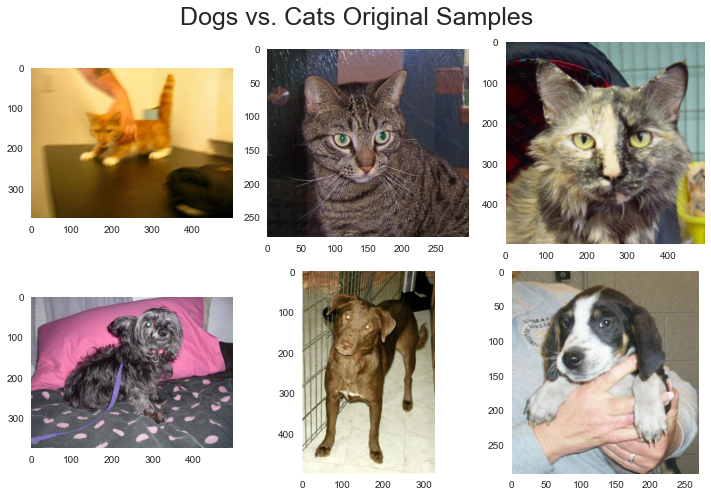

In [11]:
sample_images = pd.concat([sample0, sample1], ignore_index=True) # combine cat and dog samples as one DataFrame

# plot image samples
fig = plt.figure(figsize=(10, 7))
for i in range(len(sample_images)):
    plt.subplot(230 + i + 1) # 2 rows, 3 cols, i + 1 for index position (starts at 1)
    filename = sample_images['path'][i]
    image = cv2.imread(filename)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)) # convert color format (cv2 uses BGR and matplotlib uses RGB)
    plt.grid(False)
fig.suptitle("Dogs vs. Cats Original Samples", size=25)
plt.tight_layout()
plt.show()

> #### Initial Observations:
* Each label has an equal amount of samples, making this a **balanced classification** task.
* By looking at the indices of the sample images, it looks like the first 12,500 images are only cats
and the remaining are dogs. Certain algorithms are sensitive to the order of the data, so
the images should be shuffled.
* Some images are cropped in a way that only the face is seen, others of the whole body.
* The photos may also include a person or surrounding objects (i.e. in the bottom right image the
dog is held by a person). The photos could also be blurry (i.e. in the top left photo it looks
like the camera was slightly moved while taking the photo).

> ### Splitting the Data:
>> Before further analysis let's split the data into a training set and a testing set.
>> This will ensure avoidance of bias that could occur from learning the data as a whole.

> The training and testing data should be representative of both classes.
I noticed that the number of samples for each label are equal and decided a **stratified
split** is the optimal choice.
Although regular random sampling would have split the data nearly equally, there would
have been more bias towards one of the classes.
>> Note: As recommended earlier, StratifiedShuffleSplit also shuffles the data.
> The random_state parameter ensures that the generated shuffled split is the same each time.

In [12]:
# provides the indices to split the data
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df['label']):
    strat_train_set = df.iloc[train_index]
    strat_test_set = df.iloc[test_index]

In [13]:
# make sure that class distribution is equal
strat_test_set['label'].value_counts() / len(strat_test_set)

1    0.5
0    0.5
Name: label, dtype: float64

In [14]:
print("Training Set:", strat_train_set.shape)
print("Test Set:", strat_test_set.shape)

Training Set: (20000, 2)
Test Set: (5000, 2)


# 2. Understanding and Visualizing the Data
> ##### *The motivation for this section is to gain more insights.*

In [15]:
# deep copy of the training set
df2 = strat_train_set.copy()

In [16]:
df2.head(2)

,path,label
20022,dogs-vs-cats\train/dog.5518.jpg,1
4993,dogs-vs-cats\train/cat.3241.jpg,0


In [17]:
# function returns shape of loaded image from the provided path
def image_shape(image_path):
    return cv2.imread(image_path).shape

# function returns DataFrame containing image shapes
def load_data_shapes(image_file_names):
    shapes = []
    for i, image_file in enumerate(image_file_names):
        shapes.append(image_shape(image_file))
    return pd.DataFrame(shapes, columns=['height', 'width', 'n_channels'])

In [18]:
# use function to get list with image shapes
# image_shapes = load_data_shapes(strat_train_set['path'])
# joblib.dump(image_shapes, "dogs-vs-cats/image_shapes.pkl")
image_shapes = joblib.load(r"dogs-vs-cats/image_shapes.pkl")
image_shapes.head(3)

,height,width,n_channels
0,138,129,3
1,374,500,3
2,438,349,3


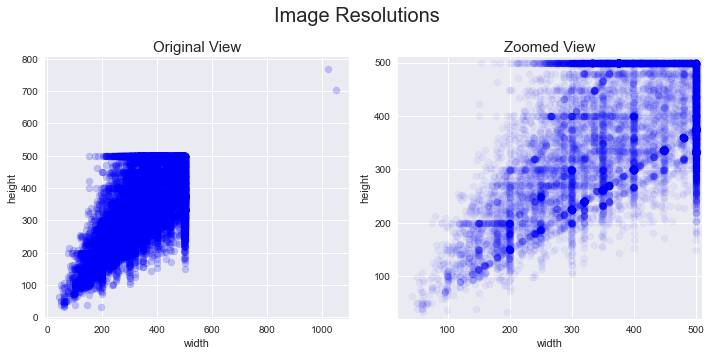

In [19]:
# plot image resolutions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.scatter(image_shapes.width, image_shapes.height, color='blue', alpha=0.2)
ax1.set_title("Original View", size=15)
points = ax2.scatter(image_shapes.width, image_shapes.height, color='blue', alpha=0.05)
ax1.set_xlabel("width")
ax1.set_ylabel("height")
ax2.set_xlim(xmin=20, xmax=510)
ax2.set_ylim(ymin=20, ymax=510)
ax2.set_title("Zoomed View", size=15)
ax2.set_xlabel("width")
ax2.set_ylabel("height")
fig.suptitle("Image Resolutions", size=20)
plt.tight_layout()
plt.show()

In [20]:
# minimum height
image_shapes["height"].min()

32

In [21]:
# minimum width
image_shapes["width"].min()

42

In [22]:
# check the number of channels
image_shapes.n_channels.unique()

array([3], dtype=int64)

> Observations:
* Most image resolutions are 500x500 or less. There is also a fair amount around 400x400,
300x300, and 200x200.
* The images are in color, meaning the number of pixels chosen for the width and height will be multiplied by 3.
This should be taken into account since it adds a substantial amount of features, as opposed to using one channel
(i.e. grayscale).

# 3. Pre-Processing the Data

## Choosing Pre-processing Implementations
> In this next part, I will evaluate several pre-processing options.
>
>> Important Notes:
* In order to use the data for ML algorithms, all images need to be processed into the **same size**.
* The pixels represent the features in the data. **The larger the size, the higher the complexity**.
* Increasing small images can stretch the pixels, so it could be better to stay in the range of the
**smaller image ratios** and downsize the larger images.
* Training a baseline model on the various sizes and transformations can be used as an evaluation measure
to help determine the best pre-processing implementation.
>
> ### Choosing the Right Size With Progressive Resizing:
> The **progressive resizing** approach is to start rescaling the images from a small size, gradually increasing it.
>> Note: Since the minimum height of the images is 32 and minimum width is 42, starting from 30x30 seems fitting.
>
> ### Image Transformation Options:
> I will try each size on 3 different transformations (in order from highest to lowest complexity):
>> Transformations:
1. Color
2. Grayscale
3. Canny Edge Detection
>>
>> #### What is Canny Edge Detection?
> This multi-stage algorithm (developed by John F. Canny) identifies the edges in images.
> This provides a simple way to pre-process the images and detect objects in them.
> The resulting image is a binary one, which overall simplifies the data and can reduce computational time.
>>> Note: The algorithm is based on grayscale images.

#### The following functions read the data:

In [23]:
# function sets global variables
def set_params(n_rows, n_cols, n_channels, is_canny):
    global ROWS, COLUMNS, CHANNELS, IS_CANNY
    ROWS = n_rows
    COLUMNS = n_cols
    CHANNELS = n_channels
    IS_CANNY = is_canny


# function loads images according to the global variables set
# cubic interpolation results in high quality images when shrinking images
def read_resize_img(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR)
    if CHANNELS == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # convert image from BGR to RGB
    elif CHANNELS == 1:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert image to grayscale
        if IS_CANNY:
            img = cv2.resize(img, (ROWS, COLUMNS), interpolation=cv2.INTER_CUBIC)
            img = cv2.Canny(img, 100, 200) # cv2 canny recommended threshold (upper:lower ratio) between 2:1 and 3:1
            return img
    return cv2.resize(img, (ROWS, COLUMNS), interpolation=cv2.INTER_CUBIC)


# function returns the data as a matrix containing the pixel values and y array with the corresponding labels
# input parameters are provided for setting the chosen ratio and transformations
def prep_data(images, n_rows, n_cols, n_channels, is_canny):
    set_params(n_rows, n_cols, n_channels, is_canny) # set global variables with inserted values
    m = len(images) # number of instances
    n_pixels = ROWS * COLUMNS * CHANNELS # number of features
    X = np.ndarray((m, n_pixels), dtype=np.uint8)
    y = np.zeros((m, 1), dtype=np.uint8)
    for i, img_file in enumerate(images):
        img = read_resize_img(img_file)
        X[i, :] = np.squeeze(img.reshape((n_pixels, 1)))  # squeeze removes useless one-dimensional arrays
        if '/dog' in img_file:
            y[i, 0] = 1
        elif '/cat' in img_file:
            y[i, 0] = 0
        else:  # if needed for the test set on kaggle (each image has an id instead of a class)
            y[i, 0] = img_file.split('/')[-1].split('.')[0]
        if i % 5000 == 0:
            print("Loading: {}/{}".format(i, m))  # print loading progress
    print("Finished Loading Data")
    return X, y.flatten() # flatten returns copy of the vector column as a row

> ### Feature Scaling
>
> Although the pixel values are in a known range [0,255], scaling the data can make a crucial difference
> (especially if the learning algorithm relies on calculating distances).
>
> Chosen feature scale:
>
> Standardizing centers the data so that it has a zero mean and a standard deviation of 1.
> Furthermore, dimensionality reduction should be useful later on since the data will contain a large
> amount of features (i.e. PCA is assumes the data has zero mean).
>
> Therefore, standard scaling is the ideal option.

In [24]:
# create transformation pipeline
full_pipeline = Pipeline([
    ('std_scl', StandardScaler()),
])

In [25]:
# original sample images
img1_before = strat_train_set['path'][0:1].iloc[0]
img2_before = strat_train_set['path'][1:2].iloc[0]

# function plots sample images next to transformed samples
def plot_before_after(img1, img2):
    fig, ax = plt.subplots(1, 4, figsize=(14,4)) # define figure and number of subplots
    # plot first image before
    image = cv2.imread(img1_before)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax[0].imshow(image)
    ax[0].grid(False)
    ax[0].set_title("Before", size=15)
    # plot first image after
    image = img1.reshape((ROWS, COLUMNS, CHANNELS))
    ax[1].imshow(image, cmap='gray')
    ax[1].grid(False)
    ax[1].set_title("After", size=15)
    # plot second image before
    image = cv2.imread(img2_before)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax[2].imshow(image)
    ax[2].grid(False)
    ax[2].set_title("Before", size=15)
    # plot second image after
    image = img2.reshape((ROWS, COLUMNS, CHANNELS))
    ax[3].imshow(image, cmap='gray')
    ax[3].grid(False)
    ax[3].set_title("After", size=15)

    plt.tight_layout()
    plt.show()

> As previously mentioned, the number of instances for each class in the training set are equal.
>
> Chosen evaluation metric:
>
> Accuracy works well with balanced classification tasks.
> It is also the most intuitive metric and simplest to understand.
>> Note:
* Accuracy is sensitive to the test size. Therefore, I will use 4 cross-validation folds
(total of 5,000 instances in each test fold).
* Since the features consist of pixel values (a fixed range), it is likely that the testing data would fit the
transformers nearly the same. This means that cross-validation should give good assessment
of the performance on unseen data, even when evaluating only from the fitted and transformed training data.

In [26]:
# function for evaluating cross validation scores and for easy model comparison
def display_scores(scores):
    print("Cross-Validation Scores:")
    print("Scores:", scores)
    print("Mean:", round(scores.mean(), 5))
    print("Standard Deviation:", round(scores.std(), 5))

### That was a lot of information! Here's a quick recap:
1. Start rescaling from 30x30 and gradually increase.
2. Train a Logistic Regression model (or other baseline models) on various the data transformations.
3. Evaluate the accuracy score.
4. Repeat the previous steps a few times.
5. Choose the optimal scale and colors.

## Aspect Ratio: 30x30

> ### 30x30x3 Color

Data shape: (20000, 2700)
Target shape: (20000,)


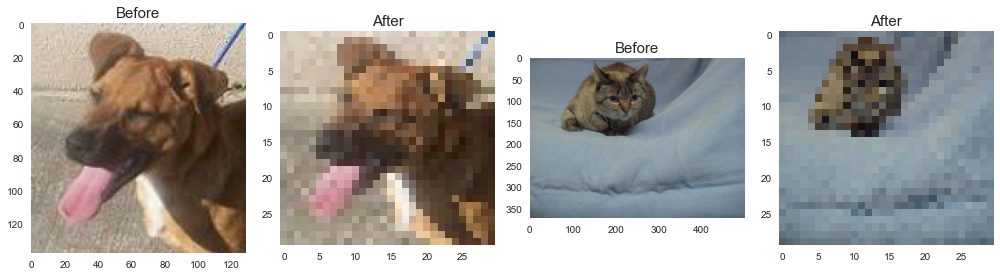

In [27]:
# X_30, y_30 = prep_data(strat_train_set["path"], 30, 30, 3, is_canny=False)
# joblib.dump(X_30, "dogs-vs-cats/data/X_30.pkl")
# joblib.dump(y_30, "dogs-vs-cats/data/y_30.pkl")

X_30 = joblib.load(r"dogs-vs-cats/data/X_30.pkl")
y_30 = joblib.load(r"dogs-vs-cats/data/y_30.pkl")
set_params(30, 30, 3, is_canny=False)

print("Data shape:", X_30.shape)
print("Target shape:", y_30.shape)

plot_before_after(X_30[0], X_30[1])

X_30 = full_pipeline.fit_transform(X_30)

In [28]:
#  log_reg_30 = LogisticRegression(random_state=42, n_jobs=-1)
# log_reg_30.fit(X_30, y_30)
# joblib.dump(log_reg_30, "dogs-vs-cats/models/log_reg_30.pkl")
log_reg_30 = joblib.load(r"dogs-vs-cats/models/log_reg_30.pkl")

# log_reg_30_pred = log_reg_30.predict(X_30)
# joblib.dump(log_reg_30_pred, "dogs-vs-cats/pred/log_reg_30_pred.pkl")
log_reg_30_pred = joblib.load(r"dogs-vs-cats/pred/log_reg_30_pred.pkl")
print("Training Set Accuracy:", metrics.accuracy_score(y_30, log_reg_30_pred))

Training Set Accuracy: 0.68855


In [29]:
# log_reg_30_scores = cross_val_score(log_reg_30, X_30, y_30, scoring="accuracy", cv=4)
# joblib.dump(log_reg_30_scores, "dogs-vs-cats/scores/log_reg_30_scores.pkl")
log_reg_30_scores = joblib.load(r"dogs-vs-cats/scores/log_reg_30_scores.pkl")
display_scores(log_reg_30_scores)

Cross-Validation Scores:
Scores: [0.592  0.5962 0.6004 0.5972]
Mean: 0.59645
Standard Deviation: 0.003


> ### 30x30 Grayscale

Data shape: (20000, 900)
Target shape: (20000,)


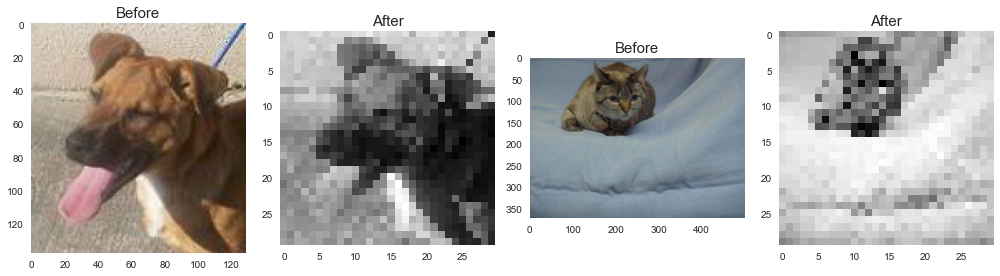

In [30]:
# X_30g, y_30g = prep_data(strat_train_set["path"], 30, 30, 1, is_canny=False)
# joblib.dump(X_30g, "dogs-vs-cats/data/X_30g.pkl")
# joblib.dump(y_30g, "dogs-vs-cats/data/y_30g.pkl")

X_30g = joblib.load(r"dogs-vs-cats/data/X_30g.pkl")
y_30g = joblib.load(r"dogs-vs-cats/data/y_30g.pkl")
set_params(30, 30, 1, is_canny=False)

print("Data shape:", X_30g.shape)
print("Target shape:", y_30g.shape)

plot_before_after(X_30g[0], X_30g[1])

X_30g = full_pipeline.fit_transform(X_30g)

In [31]:
# log_reg_30g = LogisticRegression(random_state=42, n_jobs=-1)
# log_reg_30g.fit(X_30g, y_30g)
# joblib.dump(log_reg_30g, "dogs-vs-cats/models/log_reg_30g.pkl")
log_reg_30g = joblib.load(r"dogs-vs-cats/models/log_reg_30g.pkl")

# log_reg_30g_pred = log_reg_30g.predict(X_30g)
# joblib.dump(log_reg_30g_pred, "dogs-vs-cats/pred/log_reg_30g_pred.pkl")
log_reg_30g_pred = joblib.load(r"dogs-vs-cats/pred/log_reg_30g_pred.pkl")
print("Training Set Accuracy:", metrics.accuracy_score(y_30g, log_reg_30g_pred))

Training Set Accuracy: 0.6097


In [32]:
# log_reg_30g_scores = cross_val_score(log_reg_30g, X_30g, y_30g, scoring="accuracy", cv=4)
# joblib.dump(log_reg_30g_scores, "dogs-vs-cats/scores/log_reg_30g_scores.pkl")
log_reg_30g_scores = joblib.load(r"dogs-vs-cats/scores/log_reg_30g_scores.pkl")
display_scores(log_reg_30g_scores)

Cross-Validation Scores:
Scores: [0.5456 0.5286 0.5462 0.551 ]
Mean: 0.54285
Standard Deviation: 0.00849


> ### 30x30 Canny

Data shape: (20000, 900)
Target shape: (20000,)


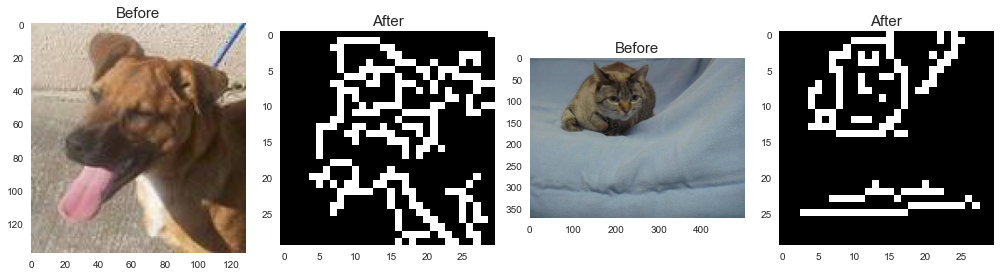

In [33]:
# X_30C, y_30C = prep_data(strat_train_set["path"], 30, 30, 1, is_canny=True)
# joblib.dump(X_30C, "dogs-vs-cats/data/X_30C.pkl")
# joblib.dump(y_30C, "dogs-vs-cats/data/y_30C.pkl")

X_30C = joblib.load(r"dogs-vs-cats/data/X_30C.pkl")
y_30C = joblib.load(r"dogs-vs-cats/data/y_30C.pkl")
set_params(30, 30, 1, is_canny=True)

print("Data shape:", X_30C.shape)
print("Target shape:", y_30C.shape)

plot_before_after(X_30C[0], X_30C[1])

X_30C = full_pipeline.fit_transform(X_30C)

In [34]:
# log_reg_30C = LogisticRegression(random_state=42, n_jobs=-1)
# log_reg_30C.fit(X_30C, y_30C)
# joblib.dump(log_reg_30C, "dogs-vs-cats/models/log_reg_30C.pkl")
log_reg_30C = joblib.load(r"dogs-vs-cats/models/log_reg_30C.pkl")

# log_reg_30C_pred = log_reg_30C.predict(X_30C)
# joblib.dump(log_reg_30C_pred, "dogs-vs-cats/pred/log_reg_30C_pred.pkl")
log_reg_30C_pred = joblib.load(r"dogs-vs-cats/pred/log_reg_30C_pred.pkl")
print("Training Set Accuracy:", metrics.accuracy_score(y_30C, log_reg_30C_pred))

Training Set Accuracy: 0.65105


In [35]:
# log_reg_30C_scores = cross_val_score(log_reg_30C, X_30C, y_30C, scoring="accuracy", cv=4)
# joblib.dump(log_reg_30C_scores, "dogs-vs-cats/scores/log_reg_30C_scores.pkl")
log_reg_30C_scores = joblib.load(r"dogs-vs-cats/scores/log_reg_30C_scores.pkl")
display_scores(log_reg_30C_scores)

Cross-Validation Scores:
Scores: [0.5924 0.595  0.5964 0.5816]
Mean: 0.59135
Standard Deviation: 0.00581


## Aspect Ratio: 40x40

> ### 40x40x3 Color

Data shape: (20000, 4800)
Target shape: (20000,)


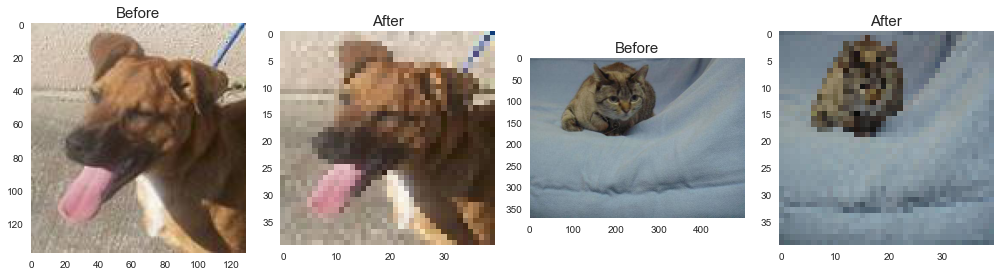

In [36]:
# X_40, y_40 = prep_data(strat_train_set["path"], 40, 40, 3, is_canny=False)
# joblib.dump(X_40, "dogs-vs-cats/data/X_40.pkl")
# joblib.dump(y_40, "dogs-vs-cats/data/y_40.pkl")

X_40 = joblib.load(r"dogs-vs-cats/data/X_40.pkl")
y_40 = joblib.load(r"dogs-vs-cats/data/y_40.pkl")
set_params(40, 40, 3, is_canny=False)

print("Data shape:", X_40.shape)
print("Target shape:", y_40.shape)

plot_before_after(X_40[0], X_40[1])

X_40 = full_pipeline.fit_transform(X_40)

In [37]:
# log_reg_40 = LogisticRegression(random_state=42, n_jobs=-1)
# log_reg_40.fit(X_40, y_40)
# joblib.dump(log_reg_40, "dogs-vs-cats/models/log_reg_40.pkl")
log_reg_40 = joblib.load(r"dogs-vs-cats/models/log_reg_40.pkl")

# log_reg_40_pred = log_reg_40.predict(X_40)
# joblib.dump(log_reg_40_pred, "dogs-vs-cats/pred/log_reg_40_pred.pkl")
log_reg_40_pred = joblib.load(r"dogs-vs-cats/pred/log_reg_40_pred.pkl")
print("Training Set Accuracy:", metrics.accuracy_score(y_40, log_reg_40_pred))

Training Set Accuracy: 0.69485


In [38]:
# log_reg_40_scores = cross_val_score(log_reg_40, X_40, y_40, scoring="accuracy", cv=4)
# joblib.dump(log_reg_40_scores, "dogs-vs-cats/scores/log_reg_40_scores.pkl")
log_reg_40_scores = joblib.load(r"dogs-vs-cats/scores/log_reg_40_scores.pkl")
display_scores(log_reg_40_scores)

Cross-Validation Scores:
Scores: [0.5776 0.5774 0.5798 0.5762]
Mean: 0.57775
Standard Deviation: 0.0013


> ### 40x40 Grayscale

Data shape: (20000, 1600)
Target shape: (20000,)


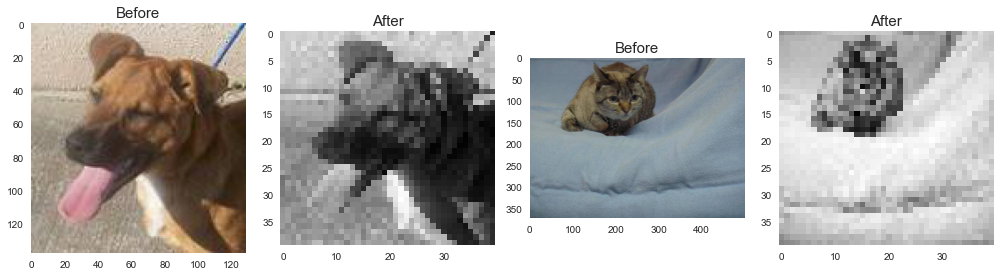

In [39]:
# X_40g, y_40g = prep_data(strat_train_set["path"], 40, 40, 1, is_canny=False)
# joblib.dump(X_40g, "dogs-vs-cats/data/X_40g.pkl")
# joblib.dump(y_40g, "dogs-vs-cats/data/y_40g.pkl")

X_40g = joblib.load(r"dogs-vs-cats/data/X_40g.pkl")
y_40g = joblib.load(r"dogs-vs-cats/data/y_40g.pkl")
set_params(40, 40, 1, is_canny=False)

print("Data shape:", X_40g.shape)
print("Target shape:", y_40g.shape)

plot_before_after(X_40g[0], X_40g[1])

X_40g = full_pipeline.fit_transform(X_40g)

In [40]:
# log_reg_40g = LogisticRegression(random_state=42, n_jobs=-1)
# log_reg_40g.fit(X_40g, y_40g)
# joblib.dump(log_reg_40g, "dogs-vs-cats/models/log_reg_40g.pkl")
log_reg_40g = joblib.load(r"dogs-vs-cats/models/log_reg_40g.pkl")

# log_reg_40g_pred = log_reg_40g.predict(X_40g)
# joblib.dump(log_reg_40g_pred, "dogs-vs-cats/pred/log_reg_40g_pred.pkl")
log_reg_40g_pred = joblib.load(r"dogs-vs-cats/pred/log_reg_40g_pred.pkl")
print("Training Set Accuracy:", metrics.accuracy_score(y_40g, log_reg_40g_pred))

Training Set Accuracy: 0.63075


In [41]:
# log_reg_40g_scores = cross_val_score(log_reg_40g, X_40g, y_40g, scoring="accuracy", cv=4)
# joblib.dump(log_reg_40g_scores, "dogs-vs-cats/scores/log_reg_40g_scores.pkl")
log_reg_40g_scores = joblib.load(r"dogs-vs-cats/scores/log_reg_40g_scores.pkl")
display_scores(log_reg_40g_scores)

Cross-Validation Scores:
Scores: [0.5308 0.5226 0.5256 0.5284]
Mean: 0.52685
Standard Deviation: 0.00307


> ### 40x40 Canny

Data shape: (20000, 1600)
Target shape: (20000,)


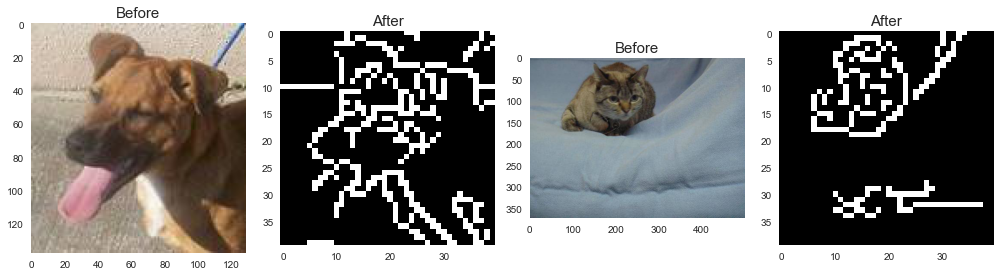

In [42]:
# X_40C, y_40C = prep_data(strat_train_set["path"], 40, 40, 1, is_canny=True)
# joblib.dump(X_40C, "dogs-vs-cats/data/X_40C.pkl")
# joblib.dump(y_40C, "dogs-vs-cats/data/y_40C.pkl")

X_40C = joblib.load(r"dogs-vs-cats/data/X_40C.pkl")
y_40C = joblib.load(r"dogs-vs-cats/data/y_40C.pkl")
set_params(40, 40, 1, is_canny=True)

print("Data shape:", X_40C.shape)
print("Target shape:", y_40C.shape)

plot_before_after(X_40C[0], X_40C[1])

X_40C = full_pipeline.fit_transform(X_40C)

In [43]:
# log_reg_40C = LogisticRegression(random_state=42, n_jobs=-1)
# log_reg_40C.fit(X_40C, y_40C)
# joblib.dump(log_reg_40C, "dogs-vs-cats/models/log_reg_40C.pkl")
log_reg_40C = joblib.load(r"dogs-vs-cats/models/log_reg_40C.pkl")

# log_reg_40C_pred = log_reg_40C.predict(X_40C)
# joblib.dump(log_reg_40C_pred, "dogs-vs-cats/pred/log_reg_40C_pred.pkl")
log_reg_40C_pred = joblib.load(r"dogs-vs-cats/pred/log_reg_40C_pred.pkl")
print("Training Set Accuracy:", metrics.accuracy_score(y_40C, log_reg_40C_pred))

Training Set Accuracy: 0.67395


In [44]:
# log_reg_40C_scores = cross_val_score(log_reg_40C, X_40C, y_40C, scoring="accuracy", cv=4)
# joblib.dump(log_reg_40C_scores, "dogs-vs-cats/scores/log_reg_40C_scores.pkl")
log_reg_40C_scores = joblib.load(r"dogs-vs-cats/scores/log_reg_40C_scores.pkl")
display_scores(log_reg_40C_scores)

Cross-Validation Scores:
Scores: [0.58   0.5854 0.5892 0.5828]
Mean: 0.58435
Standard Deviation: 0.00339


## Aspect Ratio: 50x50

> ### 50x50x3 Color

Data shape: (20000, 7500)
Target shape: (20000,)


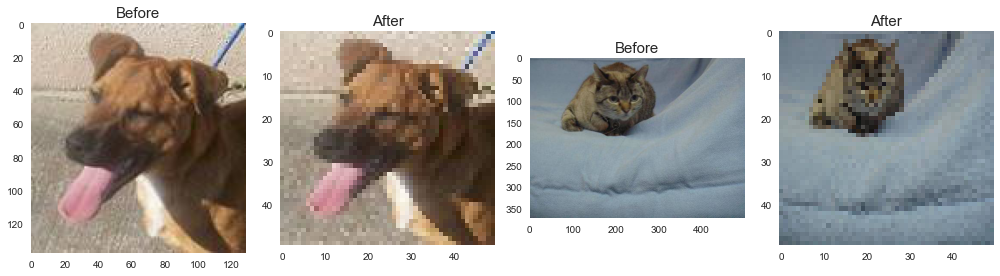

In [45]:
# X_50, y_50 = prep_data(strat_train_set["path"], 50, 50, 3, is_canny=False)
# joblib.dump(X_50, "dogs-vs-cats/data/X_50.pkl")
# joblib.dump(y_50, "dogs-vs-cats/data/y_50.pkl")

X_50 = joblib.load(r"dogs-vs-cats/data/X_50.pkl")
y_50 = joblib.load(r"dogs-vs-cats/data/y_50.pkl")
set_params(50, 50, 3, is_canny=False)

print("Data shape:", X_50.shape)
print("Target shape:", y_50.shape)

plot_before_after(X_50[0], X_50[1])

X_50 = full_pipeline.fit_transform(X_50)

In [46]:
# log_reg_50 = LogisticRegression(random_state=42, n_jobs=-1)
# log_reg_50.fit(X_50, y_50)
# joblib.dump(log_reg_50, "dogs-vs-cats/models/log_reg_50.pkl")
log_reg_50 = joblib.load(r"dogs-vs-cats/models/log_reg_50.pkl")

# log_reg_50_pred = log_reg_50.predict(X_50)
# joblib.dump(log_reg_50_pred, "dogs-vs-cats/pred/log_reg_50_pred.pkl")
log_reg_50_pred = joblib.load(r"dogs-vs-cats/pred/log_reg_50_pred.pkl")
print("Training Set Accuracy:", metrics.accuracy_score(y_50, log_reg_50_pred))

Training Set Accuracy: 0.7192


In [47]:
# log_reg_50_scores = cross_val_score(log_reg_50, X_50, y_50, scoring="accuracy", cv=4)
# joblib.dump(log_reg_50_scores, "dogs-vs-cats/scores/log_reg_50_scores.pkl")
log_reg_50_scores = joblib.load(r"dogs-vs-cats/scores/log_reg_50_scores.pkl")
display_scores(log_reg_50_scores)

Cross-Validation Scores:
Scores: [0.5674 0.5666 0.5694 0.5742]
Mean: 0.5694
Standard Deviation: 0.00295


> ### 50x50 Grayscale

Data shape: (20000, 2500)
Target shape: (20000,)


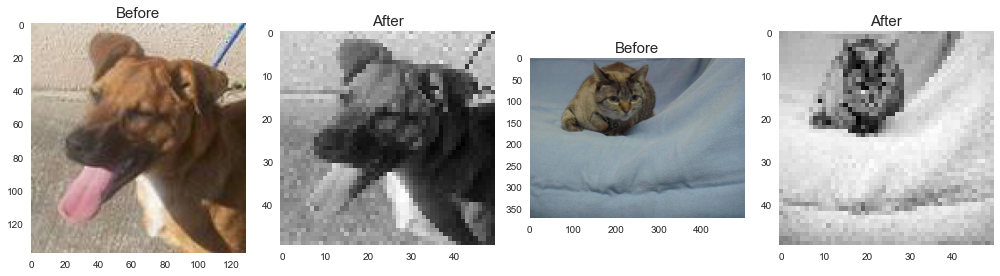

In [48]:
# X_50g, y_50g = prep_data(strat_train_set["path"], 50, 50, 1, is_canny=False)
# joblib.dump(X_50g, "dogs-vs-cats/data/X_50g.pkl")
# joblib.dump(y_50g, "dogs-vs-cats/data/y_50g.pkl")

X_50g = joblib.load(r"dogs-vs-cats/data/X_50g.pkl")
y_50g = joblib.load(r"dogs-vs-cats/data/y_50g.pkl")
set_params(50, 50, 1, is_canny=False)

print("Data shape:", X_50g.shape)
print("Target shape:", y_50g.shape)

plot_before_after(X_50g[0], X_50g[1])

X_50g = full_pipeline.fit_transform(X_50g)

In [49]:
# log_reg_50g = LogisticRegression(random_state=42, n_jobs=-1)
# log_reg_50g.fit(X_50g, y_50g)
# joblib.dump(log_reg_50g, "dogs-vs-cats/models/log_reg_50g.pkl")
log_reg_50g = joblib.load(r"dogs-vs-cats/models/log_reg_50g.pkl")

# log_reg_50g_pred = log_reg_50g.predict(X_50g)
# joblib.dump(log_reg_50g_pred, "dogs-vs-cats/pred/log_reg_50g_pred.pkl")
log_reg_50g_pred = joblib.load(r"dogs-vs-cats/pred/log_reg_50g_pred.pkl")
print("Training Set Accuracy:", metrics.accuracy_score(y_50g, log_reg_50g_pred))

Training Set Accuracy: 0.66085


In [50]:
# log_reg_50g_scores = cross_val_score(log_reg_50g, X_50g, y_50g, scoring="accuracy", cv=4)
# joblib.dump(log_reg_50g_scores, "dogs-vs-cats/scores/log_reg_50g_scores.pkl")
log_reg_50g_scores = joblib.load(r"dogs-vs-cats/scores/log_reg_50g_scores.pkl")
display_scores(log_reg_50g_scores)

Cross-Validation Scores:
Scores: [0.5278 0.5258 0.5222 0.5408]
Mean: 0.52915
Standard Deviation: 0.00702


> ### 50x50 Canny

Data shape: (20000, 2500)
Target shape: (20000,)


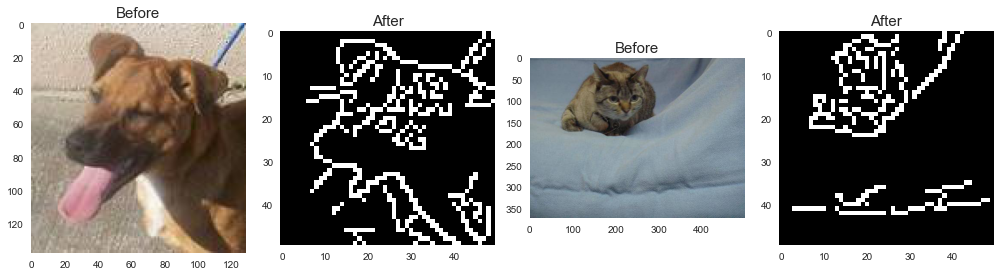

In [51]:
# X_50C, y_50C = prep_data(strat_train_set["path"], 50, 50, 1, is_canny=True)
# joblib.dump(X_50C, "dogs-vs-cats/data/X_50C.pkl")
# joblib.dump(y_50C, "dogs-vs-cats/data/y_50C.pkl")

X_50C = joblib.load(r"dogs-vs-cats/data/X_50C.pkl")
y_50C = joblib.load(r"dogs-vs-cats/data/y_50C.pkl")
set_params(50, 50, 1, is_canny=True)

print("Data shape:", X_50C.shape)
print("Target shape:", y_50C.shape)

plot_before_after(X_50C[0], X_50C[1])

X_50C = full_pipeline.fit_transform(X_50C)

In [52]:
# log_reg_50C = LogisticRegression(random_state=42, n_jobs=-1)
# log_reg_50C.fit(X_50C, y_50C)
# joblib.dump(log_reg_50C, "dogs-vs-cats/models/log_reg_50C.pkl")
log_reg_50C = joblib.load(r"dogs-vs-cats/models/log_reg_50C.pkl")

# log_reg_50C_pred = log_reg_50C.predict(X_50C)
# joblib.dump(log_reg_50C_pred, "dogs-vs-cats/pred/log_reg_50C_pred.pkl")
log_reg_50C_pred = joblib.load(r"dogs-vs-cats/pred/log_reg_50C_pred.pkl")
print("Training Set Accuracy:", metrics.accuracy_score(y_50C, log_reg_50C_pred))

Training Set Accuracy: 0.69355


In [53]:
# log_reg_50C_scores = cross_val_score(log_reg_50C, X_50C, y_50C, scoring="accuracy", cv=4)
# joblib.dump(log_reg_50C_scores, "dogs-vs-cats/scores/log_reg_50C_scores.pkl")
log_reg_50C_scores = joblib.load(r"dogs-vs-cats/scores/log_reg_50C_scores.pkl")
display_scores(log_reg_50C_scores)

Cross-Validation Scores:
Scores: [0.571  0.5692 0.5696 0.5574]
Mean: 0.5668
Standard Deviation: 0.00547


> #### Observations:
* As the size increases, the model fits the training set better (possibly overfitting it).
However, cross-validation accuracy decreased, meaning that the models performed worse
on unseen data.
* Grayscale had the lowest accuracy in each scale.

## 30x30x3 Color vs. 30x30 Canny

> The transformations have narrowed down to two options: 30x30 color and canny.
>
> To help decide which is better, I'll train 2 additional baseline models:
> KNN and Decision Tree Classifier.
> The diverse algorithms should help decide which transformation is better.

> ### 30x30x3 Color: KNN, Decision Tree

In [54]:
# knn_clf_30 = KNeighborsClassifier(n_jobs=-1)
# knn_clf_30.fit(X_30, y_30)
# joblib.dump(knn_clf_30, "dogs-vs-cats/models/knn_clf_30.pkl")
knn_clf_30 = joblib.load(r"dogs-vs-cats/models/knn_clf_30.pkl")

# knn_clf_30_pred = knn_clf_30.predict(X_30)
# joblib.dump(knn_clf_30_pred, "dogs-vs-cats/pred/knn_clf_30_pred.pkl")
knn_clf_30_pred = joblib.load(r"dogs-vs-cats/pred/knn_clf_30_pred.pkl")
print("KNN Training Set Accuracy:", metrics.accuracy_score(y_30, knn_clf_30_pred))

# tree_clf_30 = DecisionTreeClassifier(random_state=42)
# tree_clf_30.fit(X_30, y_30)
# joblib.dump(tree_clf_30, "dogs-vs-cats/models/tree_clf_30.pkl")
tree_clf_30 = joblib.load(r"dogs-vs-cats/models/tree_clf_30.pkl")

# tree_clf_30_pred = tree_clf_30.predict(X_30)
# joblib.dump(tree_clf_30_pred, "dogs-vs-cats/pred/tree_clf_30_pred.pkl")
tree_clf_30_pred = joblib.load(r"dogs-vs-cats/pred/tree_clf_30_pred.pkl")
print("Decision Tree Training Set Accuracy:", metrics.accuracy_score(y_30, tree_clf_30_pred))

KNN Training Set Accuracy: 0.69635
Decision Tree Training Set Accuracy: 1.0


In [55]:
# knn_clf_30_scores = cross_val_score(knn_clf_30, X_30, y_30, scoring="accuracy", cv=4)
# joblib.dump(knn_clf_30_scores, "dogs-vs-cats/scores/knn_clf_30_scores.pkl")
knn_clf_30_scores = joblib.load(r"dogs-vs-cats/scores/knn_clf_30_scores.pkl")
print("KNN-")
display_scores(knn_clf_30_scores)
print()
# tree_clf_30_scores = cross_val_score(tree_clf_30, X_30, y_30, scoring="accuracy", cv=4)
# joblib.dump(tree_clf_30_scores, "dogs-vs-cats/scores/tree_clf_30_scores.pkl")
tree_clf_30_scores = joblib.load(r"dogs-vs-cats/scores/tree_clf_30_scores.pkl")
print("Decision Tree-")
display_scores(tree_clf_30_scores)

KNN-
Cross-Validation Scores:
Scores: [0.5498 0.5586 0.5552 0.5334]
Mean: 0.54925
Standard Deviation: 0.00967

Decision Tree-
Cross-Validation Scores:
Scores: [0.5548 0.5592 0.5546 0.5622]
Mean: 0.5577
Standard Deviation: 0.00318


> ### 30x30 Canny: KNN, Decision Tree

In [56]:
# knn_clf_30C = KNeighborsClassifier(n_jobs=-1)
# knn_clf_30C.fit(X_30C, y_30C)
# joblib.dump(knn_clf_30C, "dogs-vs-cats/models/knn_clf_30C.pkl")
knn_clf_30C = joblib.load(r"dogs-vs-cats/models/knn_clf_30C.pkl")

# knn_clf_30C_pred = knn_clf_30C.predict(X_30C)
# joblib.dump(knn_clf_30C_pred, "dogs-vs-cats/pred/knn_clf_30C_pred.pkl")
knn_clf_30C_pred = joblib.load(r"dogs-vs-cats/pred/knn_clf_30C_pred.pkl")
print("KNN Training Set Accuracy:", metrics.accuracy_score(y_30C, knn_clf_30C_pred))

# tree_clf_30C = DecisionTreeClassifier(random_state=42)
# tree_clf_30C.fit(X_30C, y_30C)
# joblib.dump(tree_clf_30C, "dogs-vs-cats/models/tree_clf_30C.pkl")
tree_clf_30C = joblib.load(r"dogs-vs-cats/models/tree_clf_30C.pkl")

# tree_clf_30C_pred = tree_clf_30C.predict(X_30C)
# joblib.dump(tree_clf_30C_pred, "dogs-vs-cats/pred/tree_clf_30C_pred.pkl")
tree_clf_30C_pred = joblib.load(r"dogs-vs-cats/pred/tree_clf_30C_pred.pkl")
print("Decision Tree Training Set Accuracy:", metrics.accuracy_score(y_30C, tree_clf_30C_pred))

KNN Training Set Accuracy: 0.71715
Decision Tree Training Set Accuracy: 1.0


In [57]:
# knn_clf_30C_scores = cross_val_score(knn_clf_30C, X_30C, y_30C, scoring="accuracy", cv=4)
# joblib.dump(knn_clf_30C_scores, "dogs-vs-cats/scores/knn_clf_30C_scores.pkl")
knn_clf_30C_scores = joblib.load(r"dogs-vs-cats/scores/knn_clf_30C_scores.pkl")
print("KNN-")
display_scores(knn_clf_30C_scores)

print()

# tree_clf_30C_scores = cross_val_score(tree_clf_30C, X_30C, y_30C, scoring="accuracy", cv=4)
# joblib.dump(tree_clf_30C_scores, "dogs-vs-cats/scores/tree_clf_30C_scores.pkl")
tree_clf_30C_scores = joblib.load(r"dogs-vs-cats/scores/tree_clf_30C_scores.pkl")
print("Decision Tree-")
display_scores(tree_clf_30C_scores)

KNN-
Cross-Validation Scores:
Scores: [0.5072 0.5064 0.513  0.5032]
Mean: 0.50745
Standard Deviation: 0.00354

Decision Tree-
Cross-Validation Scores:
Scores: [0.5326 0.5302 0.5254 0.522 ]
Mean: 0.52755
Standard Deviation: 0.00412


> **Selected Image Pre-Processing Implementation:** 30x30 aspect ratio, color images
>
> Although the Logistic Regression showed optimistic results for both transformations, cross-validation shows that the
images in color clearly have a higher accuracy on the additional models, making it the optimal transformation.

In [58]:
# load clean copy of the training set with chosen pre-processing transformations (scale 30x30x3)
X_train, y_train = prep_data(strat_train_set["path"], 30, 30, 3, False)

Loading: 0/20000
Loading: 5000/20000
Loading: 10000/20000
Loading: 15000/20000
Finished Loading Data


In [59]:
# transform training data using pipeline
X_train_prepared = full_pipeline.fit_transform(X_train)

# 4. Training and Evaluating Models

In [60]:
# function prints accuracy and confusion matrix
def display_evaluation(actual, pred, print_report = False):
    print("Accuracy:", round(metrics.accuracy_score(actual, pred), 5))
    print("Confusion Matrix:\n", metrics.confusion_matrix(actual, pred), "\n")
    if print_report:
        print("Classification Report:\n", metrics.classification_report(actual, pred))

### Shortlist Promising Models:
> Trying many models quickly and selecting the ones that show promising results.

In [61]:
# a few instances from the training data for testing
some_data = X_train[:10]
some_labels = y_train[:10]
some_data_prepared = full_pipeline.transform(some_data)

### Dummy Classifier

In [62]:
dummy_clf = DummyClassifier(strategy="stratified", random_state=42) # stratified uses training set class distribution
dummy_clf.fit(X_train_prepared, y_train)
dummy_clf_pred = cross_val_predict(dummy_clf, X_train_prepared, y_train, cv=4)
display_evaluation(y_train, dummy_clf_pred, True)

Accuracy: 0.4964
Confusion Matrix:
 [[4964 5036]
 [5036 4964]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.50      0.50     10000
           1       0.50      0.50      0.50     10000

    accuracy                           0.50     20000
   macro avg       0.50      0.50      0.50     20000
weighted avg       0.50      0.50      0.50     20000



### 1. Logistic Regression

In [63]:
# log_reg = LogisticRegression(random_state=42, n_jobs=-1)
# log_reg.fit(X_train_prepared, y_train)
# joblib.dump(log_reg, "dogs-vs-cats/models/log_reg_1.pkl")
log_reg = joblib.load(r"dogs-vs-cats/models/log_reg_1.pkl")

print("Predictions:", log_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [1 0 0 1 1 0 0 1 0 0]
Labels: [1, 0, 1, 1, 1, 1, 0, 1, 1, 1]


In [64]:
# log_reg_scores_1 = cross_val_score(log_reg, X_train_prepared, y_train, scoring='accuracy', cv=4)
# joblib.dump(log_reg_scores_1, "dogs-vs-cats/scores/log_reg_scores_1.pkl")
log_reg_scores_1 = joblib.load(r"dogs-vs-cats/scores/log_reg_scores_1.pkl")
display_scores(log_reg_scores_1)

Cross-Validation Scores:
Scores: [0.592  0.5962 0.6004 0.5972]
Mean: 0.59645
Standard Deviation: 0.003


### 2. KNN

In [65]:
knn_clf = KNeighborsClassifier(n_jobs=-1)
# knn_clf.fit(X_train_prepared, y_train)
# joblib.dump(knn_clf, "dogs-vs-cats/models/knn_clf_2.pkl")
knn_clf = joblib.load(r"dogs-vs-cats/models/knn_clf_2.pkl")

print("Predictions:", knn_clf.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [0 0 1 1 1 1 0 1 1 1]
Labels: [1, 0, 1, 1, 1, 1, 0, 1, 1, 1]


In [66]:
# knn_scores_2 = cross_val_score(knn_clf, X_train_prepared, y_train, scoring='accuracy', cv=4)
# joblib.dump(knn_scores_2, "dogs-vs-cats/scores/knn_scores_2.pkl")
knn_scores_2 = joblib.load(r"dogs-vs-cats/scores/knn_scores_2.pkl")
display_scores(knn_scores_2)

Cross-Validation Scores:
Scores: [0.5498 0.5586 0.5552 0.5334]
Mean: 0.54925
Standard Deviation: 0.00967


### 3. Decision Tree Classifier

In [67]:
tree_clf = DecisionTreeClassifier(random_state=42)
# tree_clf.fit(X_train_prepared, y_train)
# joblib.dump(tree_clf, "dogs-vs-cats/models/tree_clf_3.pkl")
tree_clf = joblib.load(r"dogs-vs-cats/models/tree_clf_3.pkl")

print("Predictions:", tree_clf.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [1 0 1 1 1 1 0 1 1 1]
Labels: [1, 0, 1, 1, 1, 1, 0, 1, 1, 1]


In [68]:
# tree_scores_3 = cross_val_score(tree_clf, X_train_prepared, y_train, scoring='accuracy', cv=4, n_jobs=-1)
# joblib.dump(tree_scores_3, "dogs-vs-cats/scores/tree_scores_3.pkl")
tree_scores_3 = joblib.load(r"dogs-vs-cats/scores/tree_scores_3.pkl")
display_scores(tree_scores_3)

Cross-Validation Scores:
Scores: [0.5548 0.5592 0.5546 0.5622]
Mean: 0.5577
Standard Deviation: 0.00318


### 4. Random Forest Classifier

In [69]:
rf_clf = RandomForestClassifier(random_state=42, n_jobs=-1)
# rf_clf.fit(X_train_prepared, y_train)
# joblib.dump(rf_clf, "dogs-vs-cats/models/rf_clf_4.pkl")
rf_clf = joblib.load(r"dogs-vs-cats/models/rf_clf_4.pkl")

print("Predictions:", rf_clf.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [1 0 1 1 1 1 0 1 1 1]
Labels: [1, 0, 1, 1, 1, 1, 0, 1, 1, 1]


In [70]:
# rf_scores_4 = cross_val_score(rf_clf, X_train_prepared, y_train, scoring='accuracy', cv=4)
# joblib.dump(rf_scores_4, "dogs-vs-cats/scores/rf_scores_4.pkl")
rf_scores_4 = joblib.load(r"dogs-vs-cats/scores/rf_scores_4.pkl")
display_scores(rf_scores_4)

Cross-Validation Scores:
Scores: [0.6448 0.6324 0.6392 0.6432]
Mean: 0.6399
Standard Deviation: 0.00479


> Now that we have 4 different baseline models, lets evaluate dimensionality reduction techniques.

> ### K-Means Clustering
>
> Clustering is an **unsupervised learning** task which assigns similar instances to the same group.
> K-Means is a clustering algorithm that divides the data into k clusters. The new labels
> of the instances is the index of the cluster they got assigned to.
> K-Means can be used as a dimensionality reduction technique for high dimensional data (like images),
> reducing down to k dimensions.

### 5. Logistic Regression: K-Means Clustering

> Before Clustering:

In [71]:
display_scores(log_reg_scores_1)

Cross-Validation Scores:
Scores: [0.592  0.5962 0.6004 0.5972]
Mean: 0.59645
Standard Deviation: 0.003


> After Clustering:

In [72]:
kmeans_log_reg = Pipeline([
    ("kmeans", KMeans()),
    ("log_reg", LogisticRegression(random_state=42))
])

param_grid = dict(kmeans__n_clusters=range(2,70))

In [73]:
kmeans_log_reg_grid = GridSearchCV(kmeans_log_reg, param_grid, cv=4, scoring="accuracy", verbose=2, n_jobs=-1)
# kmeans_log_reg_grid.fit(X_train_prepared, y_train)
# joblib.dump(kmeans_log_reg_grid, "dogs-vs-cats/scores/kmeans_log_reg_grid.pkl")
kmeans_log_reg_grid = joblib.load(r"dogs-vs-cats/scores/kmeans_log_reg_grid.pkl")

In [74]:
kmeans_log_reg_grid.best_params_

{'kmeans__n_clusters': 63}

In [75]:
kmeans_log_reg_grid.best_score_

0.59655

In [76]:
# show results for each iteration
cvres = kmeans_log_reg_grid.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    if mean_score > 0.59:
        print(round(mean_score, 5), params)

0.59015 {'kmeans__n_clusters': 26}
0.59045 {'kmeans__n_clusters': 28}
0.59165 {'kmeans__n_clusters': 29}
0.594 {'kmeans__n_clusters': 42}
0.5901 {'kmeans__n_clusters': 46}
0.5921 {'kmeans__n_clusters': 47}
0.59055 {'kmeans__n_clusters': 49}
0.59415 {'kmeans__n_clusters': 50}
0.59195 {'kmeans__n_clusters': 51}
0.59205 {'kmeans__n_clusters': 52}
0.59185 {'kmeans__n_clusters': 53}
0.5924 {'kmeans__n_clusters': 54}
0.5926 {'kmeans__n_clusters': 55}
0.59025 {'kmeans__n_clusters': 57}
0.5963 {'kmeans__n_clusters': 58}
0.59455 {'kmeans__n_clusters': 59}
0.595 {'kmeans__n_clusters': 60}
0.5956 {'kmeans__n_clusters': 61}
0.59655 {'kmeans__n_clusters': 63}
0.5938 {'kmeans__n_clusters': 64}
0.59545 {'kmeans__n_clusters': 65}
0.5955 {'kmeans__n_clusters': 66}
0.59655 {'kmeans__n_clusters': 67}
0.5957 {'kmeans__n_clusters': 68}
0.5927 {'kmeans__n_clusters': 69}


### 6. Random Forest: K-Means Clustering

> Random Forest before Clustering:

In [77]:
display_scores(rf_scores_4)

Cross-Validation Scores:
Scores: [0.6448 0.6324 0.6392 0.6432]
Mean: 0.6399
Standard Deviation: 0.00479


> Random Forest after Clustering:

In [78]:
kmeans_rf_clf = Pipeline([
    ("kmeans", KMeans()),
    ("rf_clf", RandomForestClassifier(random_state=42, n_jobs=-1))
])

In [79]:
kmeans_rf_clf_grid = GridSearchCV(kmeans_rf_clf, param_grid, cv=4, scoring="accuracy", verbose=2)
# kmeans_rf_clf_grid.fit(X_train_prepared, y_train)
# joblib.dump(kmeans_rf_clf_grid, "dogs-vs-cats/scores/kmeans_rf_clf_grid.pkl")
kmeans_rf_clf_grid = joblib.load(r"dogs-vs-cats/scores/kmeans_rf_clf_grid.pkl")

In [80]:
kmeans_rf_clf_grid.best_params_

{'kmeans__n_clusters': 68}

In [81]:
kmeans_rf_clf_grid.best_score_

0.5943499999999999

In [82]:
# show results for each iteration
cvres = kmeans_rf_clf_grid.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    if mean_score > 0.59:
        print(round(mean_score, 5), params)

0.59035 {'kmeans__n_clusters': 51}
0.5903 {'kmeans__n_clusters': 54}
0.5903 {'kmeans__n_clusters': 58}
0.59425 {'kmeans__n_clusters': 59}
0.5904 {'kmeans__n_clusters': 66}
0.59395 {'kmeans__n_clusters': 67}
0.59435 {'kmeans__n_clusters': 68}
0.59105 {'kmeans__n_clusters': 69}


> ### PCA
> PCA is a dimensionality reduction technique that projects the data onto a lower-dimensional hyperplane.
> The ideal projection is one that preserves most of the variance with the least amount of
> information loss. There are various ways to select the number of principal components/dimensions,
> such as plotting the explained variance or measuring the performance of a Machine Learning
> algorithm if PCA is used for pre-processing.

In [83]:
pca = PCA()
pca.fit(X_train_prepared)
cumsum = np.cumsum(pca.explained_variance_ratio_) # cumulative sum (increasing by sequential addition) of components
d = np.argmax(cumsum >= 0.95) + 1
d

582

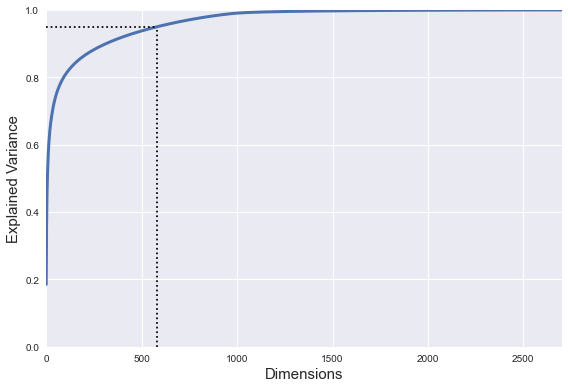

In [84]:
plt.axis([0, 2700, 0, 1])  # axis limits
plt.plot(cumsum, linewidth=3)
plt.xlabel("Dimensions", size=15)
plt.ylabel("Explained Variance", size=15)
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.tight_layout()
plt.show()

> #### Choosing the Number of Dimensions:
> Using the elbow method, around 95% explained variance is where the graph starts growing slower.
> For instance, reducing the dimensions from 2700 down to 582 will preserve 95% of the variance with only
> a little data loss.
>
> I will use pipelines and cross-validation to determine the optimal explained variance value.

### 7. Logistic Regression: PCA

> Before PCA:

In [85]:
display_scores(log_reg_scores_1)

Cross-Validation Scores:
Scores: [0.592  0.5962 0.6004 0.5972]
Mean: 0.59645
Standard Deviation: 0.003


> After PCA:

In [86]:
pca_log_reg = Pipeline([
    ("pca", PCA()),
    ("log_reg", LogisticRegression(random_state=42))
])

param_grid = [{
    "pca__n_components": [0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95]
}]

In [87]:
pca_log_reg_grid = GridSearchCV(pca_log_reg, param_grid, cv=4, scoring="accuracy", verbose=2, n_jobs=-1)
# pca_log_reg_grid.fit(X_train_prepared, y_train)
# joblib.dump(pca_log_reg_grid, "dogs-vs-cats/scores/pca_log_reg_grid.pkl")
pca_log_reg_grid = joblib.load(r"dogs-vs-cats/scores/pca_log_reg_grid.pkl")

In [88]:
pca_log_reg_grid.best_params_

{'pca__n_components': 0.9}

In [89]:
pca_log_reg_grid.best_score_

0.6097

In [90]:
# show results for each iteration
cvres = pca_log_reg_grid.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(round(mean_score, 5), params)

0.59415 {'pca__n_components': 0.85}
0.60795 {'pca__n_components': 0.86}
0.60705 {'pca__n_components': 0.87}
0.60925 {'pca__n_components': 0.88}
0.60865 {'pca__n_components': 0.89}
0.6097 {'pca__n_components': 0.9}
0.6084 {'pca__n_components': 0.91}
0.60605 {'pca__n_components': 0.92}
0.60485 {'pca__n_components': 0.93}
0.6035 {'pca__n_components': 0.94}
0.60205 {'pca__n_components': 0.95}


### 8. Random Forest: PCA

> Random Forest before PCA:

In [91]:
display_scores(rf_scores_4)

Cross-Validation Scores:
Scores: [0.6448 0.6324 0.6392 0.6432]
Mean: 0.6399
Standard Deviation: 0.00479


> Random Forest after PCA:

In [92]:
pca_rf_clf = Pipeline([
    ("pca", PCA()),
    ("rf_clf", RandomForestClassifier(random_state=42, n_jobs=-1))
])

In [93]:
pca_rf_clf_grid = GridSearchCV(pca_rf_clf, param_grid, cv=4, scoring="accuracy", verbose=2)
# pca_rf_clf_grid.fit(X_train_prepared, y_train)
# joblib.dump(pca_rf_clf_grid, "dogs-vs-cats/scores/pca_rf_clf_grid.pkl")
pca_rf_clf_grid = joblib.load(r"dogs-vs-cats/scores/pca_rf_clf_grid.pkl")

In [94]:
pca_rf_clf_grid.best_params_

{'pca__n_components': 0.86}

In [95]:
pca_rf_clf_grid.best_score_

0.62005

In [96]:
# show results for each iteration
cvres = pca_rf_clf_grid.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(round(mean_score, 5), params)

0.61955 {'pca__n_components': 0.85}
0.62005 {'pca__n_components': 0.86}
0.6166 {'pca__n_components': 0.87}
0.61465 {'pca__n_components': 0.88}
0.6153 {'pca__n_components': 0.89}
0.61395 {'pca__n_components': 0.9}
0.6119 {'pca__n_components': 0.91}
0.61175 {'pca__n_components': 0.92}
0.61525 {'pca__n_components': 0.93}
0.60785 {'pca__n_components': 0.94}
0.6044 {'pca__n_components': 0.95}


### 9. KNN: PCA

> KNN before PCA:

In [97]:
display_scores(knn_scores_2)

Cross-Validation Scores:
Scores: [0.5498 0.5586 0.5552 0.5334]
Mean: 0.54925
Standard Deviation: 0.00967


> KNN after PCA:

In [98]:
pca_knn_clf = Pipeline([
    ("pca", PCA()),
    ("knn_clf", KNeighborsClassifier(n_jobs=-1))
])

In [99]:
pca_knn_clf_grid = GridSearchCV(pca_knn_clf, param_grid, cv=4, scoring="accuracy", verbose=2)
# pca_knn_clf_grid.fit(X_train_prepared, y_train)
# joblib.dump(pca_knn_clf_grid, "dogs-vs-cats/scores/pca_knn_clf_grid.pkl")
pca_knn_clf_grid = joblib.load(r"dogs-vs-cats/scores/pca_knn_clf_grid.pkl")

In [100]:
pca_knn_clf_grid.best_params_

{'pca__n_components': 0.86}

In [101]:
pca_knn_clf_grid.best_score_

0.5890500000000001

In [102]:
# show results for each iteration
cvres = pca_knn_clf_grid.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(round(mean_score, 5), params)

0.58805 {'pca__n_components': 0.85}
0.58905 {'pca__n_components': 0.86}
0.5865 {'pca__n_components': 0.87}
0.5822 {'pca__n_components': 0.88}
0.578 {'pca__n_components': 0.89}
0.5756 {'pca__n_components': 0.9}
0.5748 {'pca__n_components': 0.91}
0.5722 {'pca__n_components': 0.92}
0.56975 {'pca__n_components': 0.93}
0.5678 {'pca__n_components': 0.94}
0.5651 {'pca__n_components': 0.95}


> #### Observations:
* Even with a high number of clusters, PCA outperformed K-Means clustering.
* It seems that the accuracy begins to decrease from 0.85 explained variance compared to the higher values.
This also makes sense when looking at the graph.
Choosing 0.86 explained variance seems like a reasonable ratio that reduces many dimensions,
preserving most of the data and model accuracy.

In [103]:
d = np.argmax(cumsum >= 0.86) + 1
d

191

> PCA reduces the dimensions from 2700 to 191!

In [104]:
# add PCA to pipeline
full_pipeline.steps.append(('pca', PCA(n_components=0.86)))
full_pipeline

Pipeline(steps=[('std_scl', StandardScaler()), ('pca', PCA(n_components=0.86))])

In [105]:
X_train_reduced = full_pipeline.fit_transform(X_train, y_train)
some_data_reduced = full_pipeline.transform(some_data)

### 10. Decision Tree (After PCA):

In [106]:
# tree_scores_10 = cross_val_score(clone(tree_clf), X_train_reduced, y_train, cv=4, scoring='accuracy', n_jobs=-1, verbose=2)
# joblib.dump(tree_scores_10, "dogs-vs-cats/scores/tree_scores_10.pkl")
tree_scores_10 = joblib.load(r"dogs-vs-cats/scores/tree_scores_10.pkl")
display_scores(tree_scores_10)

Cross-Validation Scores:
Scores: [0.555  0.5402 0.5374 0.5392]
Mean: 0.54295
Standard Deviation: 0.00703


### 11. Extra Trees Classifier:
> Very similar to the Random Forest classifier. The main difference is that Extra Trees randomly splits
> nodes, while Random Forest searches for the best split.
>> Note: Comparing prediction accuracy can help determine which model performs better on the data.

In [107]:
ex_trees = ExtraTreesClassifier(random_state=42, n_jobs=-1)
# ex_trees.fit(X_train_reduced, y_train)
# joblib.dump(ex_trees, "dogs-vs-cats/models/ex_trees_11.pkl")
ex_trees = joblib.load(r"dogs-vs-cats/models/ex_trees_11.pkl")

print("Predictions:", ex_trees.predict(some_data_reduced))
print("Labels:", list(some_labels))

Predictions: [1 0 1 1 1 1 0 1 1 1]
Labels: [1, 0, 1, 1, 1, 1, 0, 1, 1, 1]


In [108]:
# ex_trees_scores_11 = cross_val_score(ex_trees, X_train_reduced, y_train, cv=4, scoring='accuracy', verbose=2)
# joblib.dump(ex_trees_scores_11, "dogs-vs-cats/scores/ex_trees_scores_11.pkl")
ex_trees_scores_11 = joblib.load(r"dogs-vs-cats/scores/ex_trees_scores_11.pkl")
display_scores(ex_trees_scores_11)

Cross-Validation Scores:
Scores: [0.6232 0.6098 0.6074 0.601 ]
Mean: 0.61035
Standard Deviation: 0.00809


> Comparing Extra Trees to Random Forest:

In [109]:
# rf_clf_scores_11 = cross_val_score(clone(rf_clf), X_train_reduced, y_train, cv=4, scoring='accuracy', verbose=2)
# joblib.dump(rf_clf_scores_11, "dogs-vs-cats/scores/rf_clf_scores_11.pkl")
rf_clf_scores_11 = joblib.load(r"dogs-vs-cats/scores/rf_clf_scores_11.pkl")
display_scores(rf_clf_scores_11)

Cross-Validation Scores:
Scores: [0.632  0.6126 0.6218 0.6258]
Mean: 0.62305
Standard Deviation: 0.00704


> **Conclusion:** Random Forest has a higher accuracy and a lower standard deviation, making it more reliable.

### 12. AdaBoost:

In [110]:
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(), random_state=42)
# ada_clf.fit(X_train_reduced, y_train)
# joblib.dump(ada_clf, "dogs-vs-cats/models/ada_clf_12.pkl")
ada_clf = joblib.load(r"dogs-vs-cats/models/ada_clf_12.pkl")

print("Predictions:", ada_clf.predict(some_data_reduced))
print("Labels:", list(some_labels))

Predictions: [1 0 1 1 1 1 0 1 1 1]
Labels: [1, 0, 1, 1, 1, 1, 0, 1, 1, 1]


In [111]:
# ada_scores_12 = cross_val_score(ada_clf, X_train_reduced, y_train, cv=4, scoring='accuracy', n_jobs=-1, verbose=2)
# joblib.dump(ada_scores_12, "dogs-vs-cats/scores/ada_scores_12.pkl")
ada_scores_12 = joblib.load(r"dogs-vs-cats/scores/ada_scores_12.pkl")
display_scores(ada_scores_12)

Cross-Validation Scores:
Scores: [0.5612 0.5486 0.5336 0.546 ]
Mean: 0.54735
Standard Deviation: 0.0098


### 13. XGBoost:

In [112]:
xgb_clf = XGBClassifier(random_state=42, n_jobs=-1, eval_metric='error', objective='binary:logistic', use_label_encoder=False)
# xgb_clf.fit(X_train_reduced, y_train)
# joblib.dump(xgb_clf, "dogs-vs-cats/models/xgb_clf_13.pkl")
xgb_clf = joblib.load(r"dogs-vs-cats/models/xgb_clf_13.pkl")

print("Predictions:", xgb_clf.predict(some_data_reduced))
print("Labels:", list(some_labels))

Predictions: [1 0 1 1 1 1 0 1 1 1]
Labels: [1, 0, 1, 1, 1, 1, 0, 1, 1, 1]


In [113]:
xgb_clf.best_iteration

99

In [114]:
params = {
    "objective": "binary:logistic",
    "eval_metric": "error" # error rate = 1-accuracy
}

# dmatrix is a data structure used by the XGBoost library that optimizes performance
# it is needed when using the XGBoost library cross-validation
dmat_train = DMatrix(X_train_reduced, y_train)

In [115]:
# xgb_scores_13 = cv(params, dmat_train, num_boost_round=100, nfold=4,
#                   early_stopping_rounds=10, seed=42, metrics="error", verbose_eval=True)
# joblib.dump(xgb_scores_13, "dogs-vs-cats/scores/xgb_scores_13.pkl")
xgb_scores_13 = joblib.load(r"dogs-vs-cats/scores/xgb_scores_13.pkl")

In [116]:
curr_min = xgb_scores_13["test-error-mean"].argmin()
curr_min

47

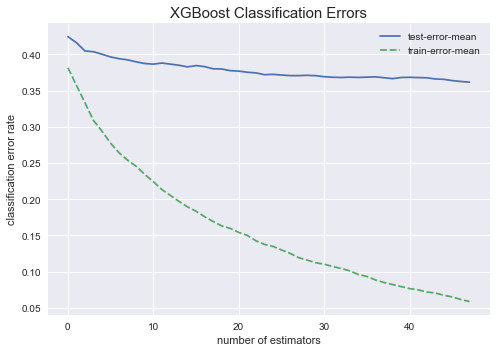

In [117]:
# plot classification errors from cross-validation
plt.figure(figsize=(7, 5))
sns.lineplot(data=[xgb_scores_13["test-error-mean"], xgb_scores_13["train-error-mean"]])
plt.xlabel("number of estimators")
plt.ylabel("classification error rate")
plt.title("XGBoost Classification Errors", size=15)
plt.tight_layout()
plt.show()

In [118]:
# best accuracy
1 - xgb_scores_13["test-error-mean"][curr_min]

0.63835

> #### Observations:
* The best models (from lowest to highest scores): KNN, Logistic Regression, Random Forest and XGBoost.
* Decision Tree and AdaBoost models had the lowest performance, both below 54% accuracy.
>
> The next step is to find the finest hyperparameters for the best models.

### Fine-Tune KNN

> Baseline Model:

In [119]:
# knn_clf_pred = cross_val_predict(knn_clf, X_train_reduced, y_train, cv=4, verbose=2, n_jobs=-1)
# joblib.dump(knn_clf_pred, "dogs-vs-cats/pred/knn_clf_pred.pkl")
knn_clf_pred = joblib.load(r"dogs-vs-cats/pred/knn_clf_pred.pkl")
display_evaluation(y_train, knn_clf_pred)

Accuracy: 0.58935
Confusion Matrix:
 [[6047 3953]
 [4260 5740]] 



> Tuning weights and penalty:

In [120]:
param_grid = [{
    "weights": ['uniform', 'distance'],
    "p": [1, 2]
}]

In [121]:
knn_clf_cv = GridSearchCV(KNeighborsClassifier(), param_grid, cv=4, scoring='accuracy', n_jobs=-1, verbose=2)
# knn_clf_cv.fit(X_train_reduced, y_train)
# joblib.dump(knn_clf_cv, "dogs-vs-cats/scores/knn_clf_cv.pkl")
knn_clf_cv = joblib.load(r"dogs-vs-cats/scores/knn_clf_cv.pkl")

In [122]:
knn_clf_cv.best_score_

0.5897

In [123]:
knn_clf2 = knn_clf_cv.best_estimator_
knn_clf2

KNeighborsClassifier(weights='distance')

In [124]:
# show results for each iteration
cvres = knn_clf_cv.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(round(mean_score, 5), params)

0.57415 {'p': 1, 'weights': 'uniform'}
0.57465 {'p': 1, 'weights': 'distance'}
0.58935 {'p': 2, 'weights': 'uniform'}
0.5897 {'p': 2, 'weights': 'distance'}


> Tuning number of neighbors:
>> Note: There is an even number of classes. It is better to choose an odd number of neighbors to
>> prevent ties.

In [125]:
# larger k values are more computationally expensive
param_grid = [{
    "n_neighbors": [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
}]

In [126]:
knn_clf_cv2 = GridSearchCV(knn_clf2, param_grid, cv=4, scoring='accuracy', n_jobs=-1, verbose=2)
# knn_clf_cv2.fit(X_train_reduced, y_train)
# joblib.dump(knn_clf_cv2, "dogs-vs-cats/scores/knn_clf_cv2.pkl")
knn_clf_cv2 = joblib.load(r"dogs-vs-cats/scores/knn_clf_cv2.pkl")

In [127]:
knn_clf_cv2.best_score_

0.61165

In [128]:
knn_clf3 = knn_clf_cv2.best_estimator_
knn_clf3

KNeighborsClassifier(n_neighbors=27, weights='distance')

In [129]:
# show results for each iteration
cvres = knn_clf_cv2.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(round(mean_score, 5), params)

0.5764 {'n_neighbors': 3}
0.5897 {'n_neighbors': 5}
0.5926 {'n_neighbors': 7}
0.5963 {'n_neighbors': 9}
0.60095 {'n_neighbors': 11}
0.60395 {'n_neighbors': 13}
0.603 {'n_neighbors': 15}
0.60695 {'n_neighbors': 17}
0.607 {'n_neighbors': 19}
0.60515 {'n_neighbors': 21}
0.60705 {'n_neighbors': 23}
0.6087 {'n_neighbors': 25}
0.61165 {'n_neighbors': 27}
0.60965 {'n_neighbors': 29}


> **Final KNN model:** Distance weights, l2 norm and 27 neighbors.

In [130]:
# knn_clf_final_pred = cross_val_predict(knn_clf3, X_train_reduced, y_train, cv=4, verbose=2, n_jobs=-1)
# joblib.dump(knn_clf_final_pred, "dogs-vs-cats/pred/knn_clf_final_pred.pkl")
knn_clf_final_pred = joblib.load(r"dogs-vs-cats/pred/knn_clf_final_pred.pkl")
display_evaluation(y_train, knn_clf_final_pred, True)

Accuracy: 0.61165
Confusion Matrix:
 [[5440 4560]
 [3207 6793]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.54      0.58     10000
           1       0.60      0.68      0.64     10000

    accuracy                           0.61     20000
   macro avg       0.61      0.61      0.61     20000
weighted avg       0.61      0.61      0.61     20000



### Fine-Tune Logistic Regression

> Baseline Model:

In [131]:
# log_reg_pred = cross_val_predict(log_reg, X_train_reduced, y_train, cv=4, verbose=2, n_jobs=-1)
# joblib.dump(log_reg_pred, "dogs-vs-cats/pred/ log_reg_pred.pkl")
log_reg_pred = joblib.load(r"dogs-vs-cats/pred/ log_reg_pred.pkl")
display_evaluation(y_train, log_reg_pred)

Accuracy: 0.60905
Confusion Matrix:
 [[6156 3844]
 [3975 6025]] 



> Tuning solver and penalty:

In [132]:
# lbfgs - default Scikit-learn solver
# both lbfgs and liblinear work well with smaller datasets
# uses a coordinate descent algorithm (moves toward the minimum one direction at a time)
# both sag and saga solvers work well with large datasets

param_grid = [{
     "solver": ["lbfgs", "liblinear", "sag", "saga"]
}]

In [133]:
log_reg_cv = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=4, scoring='accuracy', n_jobs=-1, verbose=2)
# log_reg_cv.fit(X_train_reduced, y_train)
# joblib.dump(log_reg_cv, "dogs-vs-cats/scores/log_reg_cv.pkl")
log_reg_cv = joblib.load(r"dogs-vs-cats/scores/log_reg_cv.pkl")

In [134]:
log_reg_cv.best_score_

0.6091

In [135]:
log_reg2 = log_reg_cv.best_estimator_
log_reg2

LogisticRegression(random_state=42, solver='liblinear')

In [136]:
# show results for each iteration
cvres = log_reg_cv.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(round(mean_score, 5), params)

0.60905 {'solver': 'lbfgs'}
0.6091 {'solver': 'liblinear'}
0.6091 {'solver': 'sag'}
0.60905 {'solver': 'saga'}


In [137]:
param_grid = [{
    "penalty": ["l1", "l2"], # liblinear supports l1 and l2 norms
    "C": [0.001, 0.05, 0.01, 0.1, 0.5, 1.]  # C controls regularization
    # light penalty if close to 1.0, strong penalty if close to 0.0
}]

In [138]:
log_reg_cv2 = GridSearchCV(log_reg2, param_grid, cv=4, scoring='accuracy', n_jobs=-1, verbose=2)
# log_reg_cv2.fit(X_train_reduced, y_train)
# joblib.dump(log_reg_cv2, "dogs-vs-cats/scores/log_reg_cv2.pkl")
log_reg_cv2 = joblib.load(r"dogs-vs-cats/scores/log_reg_cv2.pkl")

In [139]:
log_reg_cv2.best_score_

0.6103999999999999

In [140]:
log_reg3 = log_reg_cv2.best_estimator_
log_reg3

LogisticRegression(C=0.05, penalty='l1', random_state=42, solver='liblinear')

In [141]:
# show results for each iteration
cvres = log_reg_cv2.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(round(mean_score, 5), params)

0.583 {'C': 0.001, 'penalty': 'l1'}
0.6078 {'C': 0.001, 'penalty': 'l2'}
0.6104 {'C': 0.05, 'penalty': 'l1'}
0.60895 {'C': 0.05, 'penalty': 'l2'}
0.6066 {'C': 0.01, 'penalty': 'l1'}
0.6086 {'C': 0.01, 'penalty': 'l2'}
0.60885 {'C': 0.1, 'penalty': 'l1'}
0.6092 {'C': 0.1, 'penalty': 'l2'}
0.6092 {'C': 0.5, 'penalty': 'l1'}
0.6091 {'C': 0.5, 'penalty': 'l2'}
0.60895 {'C': 1.0, 'penalty': 'l1'}
0.6091 {'C': 1.0, 'penalty': 'l2'}


> **Final Logistic Regression model:** Liblinear solver, l1 norm and 0.05 regularization strength.

In [142]:
# log_reg_final_pred = cross_val_predict(log_reg3, X_train_reduced, y_train, cv=4, verbose=2)
# joblib.dump(log_reg_final_pred, "dogs-vs-cats/pred/log_reg_final_pred.pkl")
log_reg_final_pred = joblib.load(r"dogs-vs-cats/pred/log_reg_final_pred.pkl")
display_evaluation(y_train, log_reg_final_pred, True)

Accuracy: 0.6104
Confusion Matrix:
 [[6167 3833]
 [3959 6041]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.62      0.61     10000
           1       0.61      0.60      0.61     10000

    accuracy                           0.61     20000
   macro avg       0.61      0.61      0.61     20000
weighted avg       0.61      0.61      0.61     20000



### Fine-Tune Random Forest

> Baseline Model:

In [143]:
# rf_clf_pred = cross_val_predict(rf_clf, X_train_reduced, y_train, cv=4, verbose=2)
# joblib.dump(rf_clf_pred, "dogs-vs-cats/pred/rf_clf_pred.pkl")
rf_clf_pred = joblib.load(r"dogs-vs-cats/pred/rf_clf_pred.pkl")
display_evaluation(y_train, rf_clf_pred)

Accuracy: 0.62305
Confusion Matrix:
 [[6429 3571]
 [3968 6032]] 



> Tuning maximum number features per tree:
>> Note: If this hyperparameter is set to 'None', it evaluates all features. When dealing with high
> dimensional data (such as image classification) it can be convenient to select a smaller amount
> of features.

In [144]:
param_grid = [{
    "max_features": ['sqrt', "log2", 0.1, 0.2, 0.5, 0.8, None]  # max features that are evaluated before splitting a node
}]

In [145]:
rf_clf_cv = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=4, scoring='accuracy', verbose=2)
# rf_clf_cv.fit(X_train_reduced, y_train)
# joblib.dump(rf_clf_cv, "dogs-vs-cats/scores/rf_clf_cv.pkl")
rf_clf_cv = joblib.load(r"dogs-vs-cats/scores/rf_clf_cv.pkl")

In [146]:
rf_clf_cv.best_score_

0.6286

In [147]:
rf_clf2 = rf_clf_cv.best_estimator_
rf_clf2

RandomForestClassifier(max_features=0.1, random_state=42)

In [148]:
# show results for each iteration
cvres = rf_clf_cv.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(round(mean_score, 5), params)

0.62305 {'max_features': 'sqrt'}
0.61145 {'max_features': 'log2'}
0.6286 {'max_features': 0.1}
0.6276 {'max_features': 0.2}
0.62705 {'max_features': 0.5}
0.6262 {'max_features': 0.8}
0.6261 {'max_features': None}


> Tuning number of trees and criterion with Bagging and Pasting:
>> Note:
* More estimators tend to improve accuracy at the expense of increasing the computation time.
Additionally, from a certain amount of trees the model performance does not change much.
* The main difference between the criterion:
Gini is faster to compute and tends separate the most frequent class to its own branch,
Entropy takes longer to compute and is likely to have more balanced trees.

In [149]:
param_grid = [{
    "n_estimators": [50, 100, 200],  # max features in an individual tree
    "bootstrap": [True, False], # sampling with or without replacement
    # True (Scikit-learn default) = bagging, False = pasting
    "criterion": ["gini", "entropy"] # function to measure quality of split
}]

In [150]:
rf_clf_cv2 = GridSearchCV(rf_clf2, param_grid, cv=4, scoring="accuracy", verbose=2)
# rf_clf_cv2.fit(X_train_reduced, y_train)
# joblib.dump(rf_clf_cv2, "dogs-vs-cats/scores/rf_clf_cv2.pkl")
rf_clf_cv2 = joblib.load(r"dogs-vs-cats/scores/rf_clf_cv2.pkl")

In [151]:
rf_clf_cv2.best_score_

0.6476

In [152]:
rf_clf3 = rf_clf_cv2.best_estimator_
rf_clf3

RandomForestClassifier(bootstrap=False, criterion='entropy', max_features=0.1,
                       n_estimators=200, random_state=42)

In [153]:
# show results for each iteration
cvres = rf_clf_cv2.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(round(mean_score, 5), params)

0.6088 {'bootstrap': True, 'criterion': 'gini', 'n_estimators': 50}
0.6286 {'bootstrap': True, 'criterion': 'gini', 'n_estimators': 100}
0.64205 {'bootstrap': True, 'criterion': 'gini', 'n_estimators': 200}
0.6138 {'bootstrap': True, 'criterion': 'entropy', 'n_estimators': 50}
0.6274 {'bootstrap': True, 'criterion': 'entropy', 'n_estimators': 100}
0.64015 {'bootstrap': True, 'criterion': 'entropy', 'n_estimators': 200}
0.6157 {'bootstrap': False, 'criterion': 'gini', 'n_estimators': 50}
0.6346 {'bootstrap': False, 'criterion': 'gini', 'n_estimators': 100}
0.6424 {'bootstrap': False, 'criterion': 'gini', 'n_estimators': 200}
0.62155 {'bootstrap': False, 'criterion': 'entropy', 'n_estimators': 50}
0.63965 {'bootstrap': False, 'criterion': 'entropy', 'n_estimators': 100}
0.6476 {'bootstrap': False, 'criterion': 'entropy', 'n_estimators': 200}


> **Final Random Forest model:** 200 estimators, pasting method (sampling without replacement), entropy criterion,
> and considers 0.1 features when splitting a node.

In [154]:
# rf_clf_final_pred = cross_val_predict(rf_clf3, X_train_reduced, y_train, cv=4, verbose=2)
# joblib.dump(rf_clf_final_pred, "dogs-vs-cats/pred/rf_clf_final_pred.pkl")
rf_clf_final_pred = joblib.load(r"dogs-vs-cats/pred/rf_clf_final_pred.pkl")
display_evaluation(y_train, rf_clf_final_pred, True)

Accuracy: 0.6476
Confusion Matrix:
 [[6562 3438]
 [3610 6390]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.66      0.65     10000
           1       0.65      0.64      0.64     10000

    accuracy                           0.65     20000
   macro avg       0.65      0.65      0.65     20000
weighted avg       0.65      0.65      0.65     20000



### Fine-Tune XGBoost

> Baseline Model:

In [155]:
# xgb_clf_pred = cross_val_predict(xgb_clf, X_train_reduced, y_train, cv=4, verbose=2)
# joblib.dump(xgb_clf_pred, "dogs-vs-cats/pred/xgb_clf_pred.pkl")
xgb_clf_pred = joblib.load(r"dogs-vs-cats/pred/xgb_clf_pred.pkl")
display_evaluation(y_train, xgb_clf_pred)

Accuracy: 0.6404
Confusion Matrix:
 [[6370 3630]
 [3562 6438]] 



> Tuning the number of estimators:

In [156]:
params = {
    "objective": "binary:logistic",
    "eval_metric": "error"
}

In [157]:
# xgb_scores_cv1 = cv(params, dmat_train, num_boost_round=100, nfold=4,
#                    early_stopping_rounds=10, seed=42, metrics="error", verbose_eval=True)
# joblib.dump(xgb_scores_cv1, "dogs-vs-cats/scores/xgb_scores_cv1.pkl")
xgb_scores_cv1 = joblib.load(r"dogs-vs-cats/scores/xgb_scores_cv1.pkl")

In [158]:
curr_min = xgb_scores_cv1["test-error-mean"].argmin()
curr_min

47

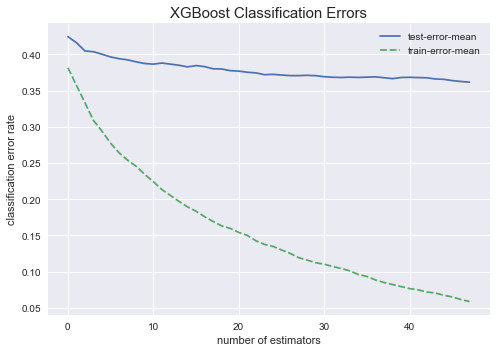

In [159]:
# plot classification errors from cross-validation
plt.figure(figsize=(7, 5))
sns.lineplot(data=[xgb_scores_cv1["test-error-mean"], xgb_scores_cv1["train-error-mean"]])
plt.xlabel("number of estimators")
plt.ylabel("classification error rate")
plt.title("XGBoost Classification Errors", size=15)
plt.tight_layout()
plt.show()

In [160]:
# best accuracy
1- xgb_scores_cv1["test-error-mean"][curr_min]

0.63835

> Tuning learning rate and tree depth:

In [161]:
param_grid = [{
    "max_depth": [3, 4, 5, 6], # maximum depth of a tree
    "learning_rate": [0.001, 0.05, 0.01, 0.1, 0.5, 1.] # controls the weights after every boost (eta)
}]

In [162]:
xgb_scores_cv2 = GridSearchCV(XGBClassifier(random_state=42, n_jobs=-1, eval_metric='error', objective="binary:logistic",
                        use_label_encoder=False, n_estimators=48), param_grid, cv=4, scoring='accuracy', verbose=2)
# xgb_scores_cv2.fit(X_train_reduced, y_train)
# joblib.dump(xgb_scores_cv2, "dogs-vs-cats/scores/xgb_scores_cv2.pkl")
xgb_scores_cv2 = joblib.load(r"dogs-vs-cats/scores/xgb_scores_cv2.pkl")

In [163]:
xgb_scores_cv2.best_score_

0.635

In [164]:
xgb_clf2 = xgb_scores_cv2.best_estimator_
xgb_clf2

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='error',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=48, n_jobs=-1,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [165]:
# show results for each iteration
cvres = xgb_scores_cv2.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(round(mean_score, 5), params)

0.5668 {'learning_rate': 0.001, 'max_depth': 3}
0.5723 {'learning_rate': 0.001, 'max_depth': 4}
0.5807 {'learning_rate': 0.001, 'max_depth': 5}
0.58325 {'learning_rate': 0.001, 'max_depth': 6}
0.61525 {'learning_rate': 0.05, 'max_depth': 3}
0.6248 {'learning_rate': 0.05, 'max_depth': 4}
0.6297 {'learning_rate': 0.05, 'max_depth': 5}
0.6309 {'learning_rate': 0.05, 'max_depth': 6}
0.58725 {'learning_rate': 0.01, 'max_depth': 3}
0.5919 {'learning_rate': 0.01, 'max_depth': 4}
0.5942 {'learning_rate': 0.01, 'max_depth': 5}
0.6027 {'learning_rate': 0.01, 'max_depth': 6}
0.6238 {'learning_rate': 0.1, 'max_depth': 3}
0.63475 {'learning_rate': 0.1, 'max_depth': 4}
0.63315 {'learning_rate': 0.1, 'max_depth': 5}
0.635 {'learning_rate': 0.1, 'max_depth': 6}
0.63205 {'learning_rate': 0.5, 'max_depth': 3}
0.6315 {'learning_rate': 0.5, 'max_depth': 4}
0.62215 {'learning_rate': 0.5, 'max_depth': 5}
0.6216 {'learning_rate': 0.5, 'max_depth': 6}
0.62095 {'learning_rate': 1.0, 'max_depth': 3}
0.6147 {'le

In [166]:
param_grid = [{
    "max_depth": [6, 7, 8, 9, 10],
    "learning_rate": [0.04, 0.05, 0.1, 0.2]
}]

In [167]:
xgb_scores_cv3 = GridSearchCV(xgb_clf2, param_grid, cv=4, scoring='accuracy', verbose=2)
# xgb_scores_cv3.fit(X_train_reduced, y_train)
# joblib.dump(xgb_scores_cv3, "dogs-vs-cats/scores/xgb_scores_cv3.pkl")
xgb_scores_cv3 = joblib.load(r"dogs-vs-cats/scores/xgb_scores_cv3.pkl")

In [168]:
xgb_scores_cv3.best_score_

0.6386000000000001

In [169]:
xgb_clf3 = xgb_scores_cv3.best_estimator_
xgb_clf3

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='error',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=8, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=48, n_jobs=-1,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [170]:
# show results for each iteration
cvres = xgb_scores_cv3.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(round(mean_score, 5), params)

0.62685 {'learning_rate': 0.04, 'max_depth': 6}
0.6328 {'learning_rate': 0.04, 'max_depth': 7}
0.6327 {'learning_rate': 0.04, 'max_depth': 8}
0.6336 {'learning_rate': 0.04, 'max_depth': 9}
0.63365 {'learning_rate': 0.04, 'max_depth': 10}
0.6309 {'learning_rate': 0.05, 'max_depth': 6}
0.6343 {'learning_rate': 0.05, 'max_depth': 7}
0.6323 {'learning_rate': 0.05, 'max_depth': 8}
0.6343 {'learning_rate': 0.05, 'max_depth': 9}
0.6365 {'learning_rate': 0.05, 'max_depth': 10}
0.635 {'learning_rate': 0.1, 'max_depth': 6}
0.63755 {'learning_rate': 0.1, 'max_depth': 7}
0.6386 {'learning_rate': 0.1, 'max_depth': 8}
0.6368 {'learning_rate': 0.1, 'max_depth': 9}
0.63625 {'learning_rate': 0.1, 'max_depth': 10}
0.63535 {'learning_rate': 0.2, 'max_depth': 6}
0.6342 {'learning_rate': 0.2, 'max_depth': 7}
0.63385 {'learning_rate': 0.2, 'max_depth': 8}
0.62785 {'learning_rate': 0.2, 'max_depth': 9}
0.635 {'learning_rate': 0.2, 'max_depth': 10}


> **Final XGBoost model:** 0.1 learning rate, maximum tree depth 8.

In [171]:
# xgb_clf_final_pred = cross_val_predict(xgb_clf3, X_train_reduced, y_train, cv=4, verbose=2)
# joblib.dump(xgb_clf_final_pred, "dogs-vs-cats/pred/xgb_clf_final_pred.pkl")
xgb_clf_final_pred = joblib.load(r"dogs-vs-cats/pred/xgb_clf_final_pred.pkl")
display_evaluation(y_train, xgb_clf_final_pred, True)

Accuracy: 0.6386
Confusion Matrix:
 [[6312 3688]
 [3540 6460]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.63      0.64     10000
           1       0.64      0.65      0.64     10000

    accuracy                           0.64     20000
   macro avg       0.64      0.64      0.64     20000
weighted avg       0.64      0.64      0.64     20000



### Voting Classifiers

> ### Hard Voting Classifier:
> Predicts the class that received the most votes.

In [172]:
voting_hard = VotingClassifier(
    estimators=[
        ('log_reg', clone(log_reg3)),
        ('knn', clone(knn_clf3)),
        ('rf_clf', clone(rf_clf3))],
    voting='hard')

In [173]:
# voting_hard_scores = cross_val_score(voting_hard, X_train_reduced, y_train, cv=4, scoring="accuracy", verbose=2)
# joblib.dump(voting_hard_scores, "dogs-vs-cats/scores/voting_hard_scores.pkl")
voting_hard_scores = joblib.load(r"dogs-vs-cats/scores/voting_hard_scores.pkl")
display_scores(voting_hard_scores)

Cross-Validation Scores:
Scores: [0.6494 0.6468 0.6492 0.654 ]
Mean: 0.64985
Standard Deviation: 0.00261


In [174]:
# voting_hard_pred = cross_val_predict(voting_hard, X_train_reduced, y_train, cv=4, verbose=2)
# joblib.dump(voting_hard_pred, "dogs-vs-cats/pred/voting_hard_pred.pkl")
voting_hard_pred = joblib.load(r"dogs-vs-cats/pred/voting_hard_pred.pkl")
display_evaluation(y_train, voting_hard_pred, True)

Accuracy: 0.64985
Confusion Matrix:
 [[6349 3651]
 [3352 6648]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.63      0.64     10000
           1       0.65      0.66      0.66     10000

    accuracy                           0.65     20000
   macro avg       0.65      0.65      0.65     20000
weighted avg       0.65      0.65      0.65     20000



> ### Soft Voting Classifier:
> Averages the predicted probabilities.

In [175]:
voting_soft = VotingClassifier(
    estimators=[
        ('log_reg', clone(log_reg3)),
        ('rf_clf', clone(rf_clf3)),
        ('xgb', clone(xgb_clf3))],
    voting='soft')

In [176]:
# voting_soft_scores = cross_val_score(voting_soft, X_train_reduced, y_train, cv=4, scoring="accuracy", verbose=2)
# joblib.dump(voting_soft_scores, "dogs-vs-cats/scores/voting_soft_scores.pkl")
voting_soft_scores = joblib.load(r"dogs-vs-cats/scores/voting_soft_scores.pkl")
display_scores(voting_soft_scores)

Cross-Validation Scores:
Scores: [0.6588 0.6422 0.6556 0.6524]
Mean: 0.65225
Standard Deviation: 0.00623


In [177]:
# voting_soft_pred = cross_val_predict(voting_soft, X_train_reduced, y_train, cv=4, verbose=2)
# joblib.dump(voting_soft_pred, "dogs-vs-cats/pred/voting_soft_pred.pkl")
voting_soft_pred = joblib.load(r"dogs-vs-cats/pred/voting_soft_pred.pkl")
display_evaluation(y_train, voting_soft_pred, True)

Accuracy: 0.65225
Confusion Matrix:
 [[6597 3403]
 [3552 6448]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.66      0.65     10000
           1       0.65      0.64      0.65     10000

    accuracy                           0.65     20000
   macro avg       0.65      0.65      0.65     20000
weighted avg       0.65      0.65      0.65     20000



### Stacking
> Stacking combines the aggregated predictions of several models to create a new
> training set. The new training set is used as input features to fit a second model that
> makes the final predictions.

In [178]:
stack_clf = StackingClassifier(
    estimators=[
        ("knn", clone(knn_clf3)),
        ("rf_clf", clone(rf_clf3)),
        ("xgb", clone(xgb_clf3))
    ],
    final_estimator=clone(log_reg3),
    verbose=2,
    cv=4, # determines cross-validation folds used to train final estimator
    n_jobs=-1,
    passthrough=True # when True- trains final estimator on original data too
)

In [179]:
# stack_clf_scores = cross_val_score(stack_clf, X_train_reduced, y_train, cv=4, scoring="accuracy", verbose=2)
# joblib.dump(stack_clf_scores, "dogs-vs-cats/scores/stack_clf_scores.pkl")
stack_clf_scores = joblib.load(r"dogs-vs-cats/scores/stack_clf_scores.pkl")
display_scores(stack_clf_scores)

Cross-Validation Scores:
Scores: [0.6648 0.6532 0.6616 0.6608]
Mean: 0.6601
Standard Deviation: 0.00426


In [180]:
# stack_clf_pred = cross_val_predict(stack_clf, X_train_reduced, y_train, cv=4, verbose=2)
# joblib.dump(stack_clf_pred, "dogs-vs-cats/pred/stack_clf_pred.pkl")
stack_clf_pred = joblib.load(r"dogs-vs-cats/pred/stack_clf_pred.pkl")
display_evaluation(y_train, stack_clf_pred, True)

Accuracy: 0.6601
Confusion Matrix:
 [[6616 3384]
 [3414 6586]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.66      0.66     10000
           1       0.66      0.66      0.66     10000

    accuracy                           0.66     20000
   macro avg       0.66      0.66      0.66     20000
weighted avg       0.66      0.66      0.66     20000



> #### Observations:
* Soft voting achieved a higher accuracy than hard voting.
* The stacking classifier model had the highest accuracy.

### The model with the highest score is the Stacking Classifier!

In [181]:
# final_model = stack_clf
# final_model.fit(X_train_reduced, y_train)
# joblib.dump(final_model, "dogs-vs-cats/models/final_model.pkl")
final_model = joblib.load(r"dogs-vs-cats/models/final_model.pkl")

# 5. Evaluating the Test Set

In [182]:
# separate test set predictors and labels
X_test, y_test = prep_data(strat_test_set["path"], 30, 30, 3, False)

Loading: 0/5000
Finished Loading Data


In [183]:
# transform test set
X_test_prepared = full_pipeline.transform(X_test)

In [184]:
# evaluate test set predictions
final_predictions = final_model.predict(X_test_prepared)
display_evaluation(y_test, final_predictions, True)

Accuracy: 0.6724
Confusion Matrix:
 [[1693  807]
 [ 831 1669]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.68      0.67      2500
           1       0.67      0.67      0.67      2500

    accuracy                           0.67      5000
   macro avg       0.67      0.67      0.67      5000
weighted avg       0.67      0.67      0.67      5000



> #### Resources:
1. <a href="https://www.kaggle.com/c/dogs-vs-cats">Dogs vs. Cats Dataset</a>
2. <a href="https://medium.com/@mrgarg.rajat/kaggle-dogs-vs-cats-challenge-complete-step-by-step-guide-part-1-a347194e55b1">Dogs vs. Cats Challenge Guide</a>
3. <a href="https://blog.roboflow.com/you-might-be-resizing-your-images-incorrectly/">You Might Be Resizing Your Images Incorrectly</a>
4. <a href="https://en.wikipedia.org/wiki/Canny_edge_detector">Canny edge detector</a>